# VQE Benchmark Suite for Lithium Hydride (LiH) - Frozen Core Version (8 Qubits)

This notebook implements a **comprehensive benchmark framework** to compare multiple ansatz implementations for VQE.

**Framework Features:**
- Tests 4 different ansatz implementations
- Runs each ansatz 3 times for statistical reliability
- Tracks comprehensive metrics for each run
- Aggregates results into comparison tables and visualizations

**Ansätze to Compare:**
1. **UCCSD** - Unitary Coupled Cluster Singles and Doubles
2. **Hardware Efficient** - Parameterized rotation layers
3. **TwoLocal** - General two-local ansatz
4. **Custom Ansatz** - To be implemented

**Metrics Tracked:**
- Circuit complexity (CNOT count, depth, parameters)
- Convergence speed and quality
- State fidelity to exact ground state
- Variance behavior
- Barren plateau indicators


In [9]:
# Install required packages
!pip install --upgrade qiskit qiskit-nature qiskit-algorithms pyscf matplotlib -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [10]:
# Import required libraries
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC
from qiskit.circuit.library import ExcitationPreserving 
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, state_fidelity
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from typing import Dict, List, Any

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Step 1: Define LiH Molecule with Frozen Core

In [11]:
# Define LiH molecule
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.595",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Run electronic structure calculation
problem_full = driver.run()

print(f"Before freeze-core:")
print(f"  Spatial orbitals: {problem_full.num_spatial_orbitals}")
print(f"  Particles:        {problem_full.num_particles}")
print(f"  Qubits:           {problem_full.num_spatial_orbitals * 2}\n")

# Apply frozen core approximation
transformer = FreezeCoreTransformer(
    freeze_core=True,
    #remove_orbitals=[4, 5]
    remove_orbitals=[5]  # Remove 2 high-energy orbitals: 6→4 spatial orbitals
)
problem = transformer.transform(problem_full)

print(f"After freeze-core:")
print(f"  Spatial orbitals: {problem.num_spatial_orbitals}")
print(f"  Particles:        {problem.num_particles}")
print(f"  Qubits:           {problem.num_spatial_orbitals * 2} ✅ (Target: 8)")
print(f"  Nuclear repulsion: {problem.nuclear_repulsion_energy:.6f} Ha")

Before freeze-core:
  Spatial orbitals: 6
  Particles:        (2, 2)
  Qubits:           12

After freeze-core:
  Spatial orbitals: 4
  Particles:        (1, 1)
  Qubits:           8 ✅ (Target: 8)
  Nuclear repulsion: 0.995318 Ha


## Step 2: Get Hamiltonian and Map to Qubits


In [12]:
# Get Hamiltonian from reduced problem
hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

# Map to qubit operator
mapper = JordanWignerMapper()
qubit_op = mapper.map(second_q_op)

print(f"Fermionic operator has {len(second_q_op)} terms")
print(f"Qubit operator has {len(qubit_op)} terms")
print(f"Number of qubits: {qubit_op.num_qubits}")


Fermionic operator has 300 terms
Qubit operator has 105 terms
Number of qubits: 8


## Step 3: Exact Solution (NumPy Solver)


In [13]:
# Exact solver for reference
numpy_solver = NumPyMinimumEigensolver()
numpy_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

exact_electronic = numpy_result.eigenvalue.real
exact_total = exact_electronic + problem.nuclear_repulsion_energy

# Get exact ground state vector for fidelity calculation
exact_state = numpy_result.eigenstate

print("Exact Solution (NumPy):")
print(f"  Electronic energy: {exact_electronic:.8f} Ha")
print(f"  Total energy:      {exact_total:.8f} Ha")


Exact Solution (NumPy):
  Electronic energy: -1.06086814 Ha
  Total energy:      -0.06555051 Ha


## Step 4: Define Benchmark Framework and Ansatz Configurations


In [14]:
def run_vqe_benchmark(ansatz, ansatz_name, run_number, qubit_op, exact_electronic, exact_state, problem, maxiter=300):
    """
    Run a single VQE benchmark with comprehensive metric tracking
    FIXED: Robust error handling in callback
    """
    decomp_ansatz = ansatz.decompose() 

    num_parameters = decomp_ansatz.num_parameters
    circuit_depth = decomp_ansatz.depth()
    circuit_size = decomp_ansatz.size()
    cnot_count = decomp_ansatz.count_ops().get('cx', 0)

    # # ##debug checks below ----##
    # # Test params
    # test_params = np.random.normal(0, 0.1, size=num_parameters)
    # param_dict = {param: test_params[i] for i, param in enumerate(ansatz.parameters)}
    # bound_circuit = ansatz.assign_parameters(param_dict)

    # # Check before decompose
    # print(f"   Before decompose:")
    # print(f"      Depth: {bound_circuit.depth()}")
    # print(f"      Gates: {bound_circuit.size()}")
    # print(f"      Ops: {bound_circuit.count_ops()}")

    # # Check after decompose  
    # decomposed = bound_circuit.decompose()
    # print(f"   After decompose:")
    # print(f"      Depth: {decomposed.depth()}")
    # print(f"      Gates: {decomposed.size()}")
    # print(f"      Ops: {decomposed.count_ops()}")    
    # #---####




    print(f"\n{'='*70}")
    print(f"Running: {ansatz_name} - Run #{run_number}")
    print(f"Optimizer: COBYLA (maxiter={maxiter})")
    print(f"Parameters: {num_parameters}, Depth: {circuit_depth}")
    print(f"{'='*70}")

    start_time = time.time() #moved here now

    
    # Initialize tracking lists
    convergence_history = []
    all_evaluations = []
    variance_history = []
    
    best_energy = [float('inf')]
    callback_error_count = [0]
    
    def callback(eval_count, parameters, mean, std):
        """Callback with robust error handling"""
        try:
            # Store all evaluations
            all_evaluations.append(mean)
            
            # Update best-so-far
            if mean < best_energy[0]:
                best_energy[0] = mean
            
            # Store best-so-far for convergence
            convergence_history.append(best_energy[0])
            
            # Extract variance (simplified - don't let this fail)
            try:
                if isinstance(std, dict):
                    variance_val = list(std.values())[0] if len(std) > 0 else 0.0
                else:
                    variance_val = std if std is not None else 0.0
                variance_history.append(variance_val)
            except:
                variance_history.append(0.0)
            
            # Print progress every 50 evaluations
            # if len(all_evaluations) % 50 == 0:
            #     print(f"    Eval {len(all_evaluations)}: E={mean:.6f} Ha, " +
            #           f"Error={abs(mean - exact_electronic)*1000:.3f} mHa")
                
            #print every eval: 
            print(f"    Eval {len(all_evaluations)}: E={mean:.6f} Ha, " +
            f"Error={abs(mean - exact_electronic)*1000:.3f} mHa")
        
        except Exception as e:
            # Count errors but don't let callback crash VQE
            callback_error_count[0] += 1
            if callback_error_count[0] == 1:  # Only print first error
                print(f"    ⚠️  Callback error: {e}")
    
    # Run VQE with COBYLA optimizer
    vqe_solver = VQE(
        StatevectorEstimator(), 
        ansatz, 
        COBYLA(maxiter=maxiter, tol=1e-6),
        callback=callback
    )
    
    # Use small random initialization to avoid symmetry/barren plateaus
    np.random.seed(42 + run_number)  # Different seed per run
    vqe_solver.initial_point = np.random.normal(0, 0.01, size=num_parameters)
    
    print(f"⏱️  Starting VQE optimization now...")  # debug
    vqe_start = time.time()  # debug
    
    result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
    
    vqe_end = time.time()  # debug
    print(f"⏱️  VQE compute_minimum_eigenvalue took: {vqe_end - vqe_start:.1f}s")  # debug

    vqe_electronic = result.eigenvalue.real
    vqe_total = vqe_electronic + problem.nuclear_repulsion_energy
    elapsed_time = time.time() - start_time
    
    # Get actual number of function evaluations
    actual_evals = getattr(result.optimizer_result, 'nfev', len(convergence_history))
    
    print(f"\n✅ Completed in {elapsed_time:.1f}s")
    print(f"   Function evaluations: {actual_evals}")
    print(f"   Callback captured: {len(convergence_history)} points")
    if callback_error_count[0] > 0:
        print(f"   Callback errors: {callback_error_count[0]}")
    
    # Calculate convergence speed
    if len(convergence_history) > 1:
        energy_range = convergence_history[0] - exact_electronic
        threshold_energy = convergence_history[0] - 0.99 * energy_range
        convergence_iter = next((i for i, e in enumerate(convergence_history) 
                                if e <= threshold_energy), len(convergence_history))
    else:
        convergence_iter = actual_evals
    
    # Calculate final state fidelity
    try:
        optimal_params = result.optimal_parameters
        if optimal_params is not None:
            param_dict = {param: optimal_params[param] for param in ansatz.parameters}
            bound_circuit = ansatz.assign_parameters(param_dict)
        else:
            bound_circuit = ansatz.assign_parameters(vqe_solver.initial_point)
        
        final_vqe_state = Statevector(bound_circuit)
        final_fidelity = state_fidelity(final_vqe_state, exact_state)
    except Exception as e:
        print(f"   ⚠️  Fidelity calculation failed: {e}")
        final_fidelity = 0.0
    
    # Calculate final metrics
    final_energy_error = abs(vqe_electronic - exact_electronic)
    final_energy_error_percent = (final_energy_error / abs(exact_electronic)) * 100
    
    print(f"   Energy Error: {final_energy_error:.6e} Ha ({final_energy_error_percent:.4f}%)")
    print(f"   Fidelity: {final_fidelity:.6f}")
    print(f"   Convergence: {convergence_iter}/{len(convergence_history)} iterations")
    
    # Plot convergence on second run (only if we have data)
    if run_number == 2 and len(convergence_history) > 1:
        print(f"\n{'*'*70}")
        print(f"📊 PLOTTING CONVERGENCE FOR {ansatz_name} - RUN #2")
        print(f"{'*'*70}\n")
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        iterations = range(1, len(convergence_history) + 1)
        
        # Plot 1: Energy convergence
        ax1.plot(iterations, convergence_history, 'b-', linewidth=2, alpha=0.7, label='VQE Energy')
        ax1.axhline(y=exact_electronic, color='r', linestyle='--', linewidth=2, label='Exact Energy')
        ax1.set_xlabel('Iteration', fontsize=12)
        ax1.set_ylabel('Electronic Energy (Ha)', fontsize=12)
        ax1.set_title(f'{ansatz_name} - Energy Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Absolute error (log scale)
        absolute_errors = [abs(energy - exact_electronic) for energy in convergence_history]
        ax2.semilogy(iterations, absolute_errors, 'g-', linewidth=2, alpha=0.7)
        ax2.set_xlabel('Iteration', fontsize=12)
        ax2.set_ylabel('Absolute Energy Error (Ha)', fontsize=12)
        ax2.set_title(f'{ansatz_name} - Error Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, which='both')
        
        plt.tight_layout()
        plot_filename = f"convergence_{ansatz_name}_run2.png"
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"✅ Convergence plot saved: {plot_filename}\n")
    
    # Return comprehensive results
    return {
        'Ansatz': ansatz_name,
        'Run': run_number,
        'CNOT_Count': cnot_count,
        'Circuit_Depth': circuit_depth,
        'Circuit_Size': circuit_size,
        'Num_Parameters': num_parameters,
        'Total_Iterations': len(convergence_history) if len(convergence_history) > 0 else actual_evals,
        'Convergence_Speed_99': convergence_iter,
        'Total_Time_sec': elapsed_time,
        'Initial_Energy_Ha': convergence_history[0] if len(convergence_history) > 0 else vqe_electronic,
        'Final_Energy_Ha': convergence_history[-1] if len(convergence_history) > 0 else vqe_electronic,
        'Exact_Energy_Ha': exact_electronic,
        'Energy_Error_Ha': final_energy_error,
        'Energy_Error_Percent': final_energy_error_percent,
        'State_Fidelity': final_fidelity,
        'Fidelity_Percent': final_fidelity * 100,
        'Avg_Variance': np.mean(variance_history) if len(variance_history) > 0 else 0.0,
        'Final_Variance': np.mean(variance_history[-100:]) if len(variance_history) > 100 else 0.0,
        'Max_Variance': max(variance_history) if len(variance_history) > 0 else 0.0,
        'Min_Variance': min(variance_history) if len(variance_history) > 0 else 0.0,
        'Gradient_Indicator': 0.0,
        'Mean_Gradient': 0.0,
        'Std_Gradient': 0.0,
        'Barren_Plateau_Status': 'N/A',
        # Store histories
        '_convergence_history': convergence_history,
        '_variance_history': variance_history,
        '_fidelity_history': [],
        '_gradient_history': []
    }

print("✅ Benchmark framework defined w/ debugging")

✅ Benchmark framework defined w/ debugging


## Step 5: Define Individual Ansätze (4 Different Implementations)


In [15]:
# Get problem parameters
num_qubits = problem.num_spatial_orbitals * 2
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

print(f"System parameters:")
print(f"  Number of qubits: {num_qubits}")
print(f"  Spatial orbitals: {num_spatial_orbitals}")
print(f"  Particles: {num_particles}")
print(f"\n{'='*70}")

# Create Hartree-Fock initial state (used by all ansätze)
hf_state = HartreeFock(
    num_spatial_orbitals,
    num_particles,
    mapper,
)

print("\n✅ Hartree-Fock initial state created")
print(f"   HF state qubits: {hf_state.num_qubits}")
print(f"\n{'='*70}\n")


System parameters:
  Number of qubits: 8
  Spatial orbitals: 4
  Particles: (1, 1)


✅ Hartree-Fock initial state created
   HF state qubits: 8




In [16]:
from qiskit.circuit.library import TwoLocal
# =============================================================================
# ANSATZ 1: UCCSD (Unitary Coupled Cluster Singles and Doubles)
# =============================================================================
print("Creating Ansatz 1: UCCSD")
print("-" * 70)

ansatz_1_UCCSD = UCCSD(
    num_spatial_orbitals,
    num_particles,
    mapper,
    initial_state=hf_state,
)

print(f"✅ UCCSD ansatz created")
print(f"   Parameters: {ansatz_1_UCCSD.num_parameters}")
print(f"   Qubits: {ansatz_1_UCCSD.num_qubits}")

# =============================================================================
# ANSATZ 2: UpCCGSD
# =============================================================================
print(f"\n{'='*70}")
print("Creating Ansatz 2: UpCCGSD: k = 2")
print("-" * 70)

def generate_upccgsd_excitations(num_spatial_orbitals, num_particles):
    """
    Generates the precise list of excitations for the UpCCGSD ansatz.
    """
    excitations = []
    
    # Loop over all unique pairs of spatial orbitals (p, q)
    for p in range(num_spatial_orbitals):
        for q in range(p + 1, num_spatial_orbitals):
            
            # 1. Generalized Singles (Spin-conserving): p -> q
            # Alpha: (2p,) -> (2q,)
            excitations.append(((2 * p,), (2 * q,)))
            # Beta: (2p+1,) -> (2q+1,)
            excitations.append(((2 * p + 1,), (2 * q + 1,)))

            # 2. Generalized Pair Doubles (Zero-seniority)
            # Annihilate pair in p (2p, 2p+1), Create pair in q (2q, 2q+1)
            excitations.append(((2 * p, 2 * p + 1), (2 * q, 2 * q + 1)))
            
    return excitations

# Create the Exact UpCCGSD Ansatz manually
k_layers = 2 

ansatz_2_UpCCGSD = UCC(
    num_spatial_orbitals=problem.num_spatial_orbitals,
    num_particles=problem.num_particles,
    qubit_mapper=mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
    # CORRECTED: Pass the function object, DO NOT call it ()
    excitations=generate_upccgsd_excitations,
    reps=k_layers 
)

print(f"✅ UpCCGSD ansatz created")
print(f"   Parameters: {ansatz_2_UpCCGSD.num_parameters}")
print(f"   Qubits: {ansatz_2_UpCCGSD.num_qubits}")
print(f"   Reps: 3, Entanglement: linear")

# =============================================================================
# ANSATZ 3: TwoLocal (RY-RZ rotations with CX entanglement)
# =============================================================================
# print(f"\n{'='*70}")
# =============================================================================
# ANSATZ 3: PC-HEA (Particle-Conserving Hardware-Efficient Ansatz)
# =============================================================================
print(f"\n{'='*70}")
print("Creating Ansatz 3: PC-HEA")
print("-" * 70)

# Create particle-conserving hardware-efficient ansatz (PC-HEA)
ansatz_3_PC_HEA = ExcitationPreserving(
    num_qubits=qubit_op.num_qubits,
    mode="fsim",          # particle-conserving entangling gate
    entanglement="linear",   # linear entanglement
    reps=4,                # depth; increase if you want more expressivity
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    )
)

# Prepend Hartree-Fock initial state
# HF state already set via initial_state parameter - no need to compose again

print(f"✅ PC-HEA ansatz created")
print(f"   Parameters: {ansatz_3_PC_HEA.num_parameters}")
print(f"   Qubits: {ansatz_3_PC_HEA.num_qubits}")
print(f"   Mode: fsim (Particle Conserving)")
print(f"   Entanglement: linear, Reps: 4")

print(f"\n{'='*70}\n")


# ANSATZ 4: QEB (Qubit Excitation-Based)
# =============================================================================
print(f"\n{'='*70}")
print("Creating Ansatz 4: QEB (Qubit Excitation-Based)")
print("-" * 70)

from qeb_ansatz import QEBansatz

ansatz_4_QEB_8q = QEBansatz(
    num_qubits=num_qubits,
    num_particles=num_particles,
    num_spatial_orbitals=num_spatial_orbitals,
    depth=1,
    include_double=True,
    use_hartree_fock_init=True,
    mapper=mapper,
)

print(f"✅ QEB_8q ansatz created")
print(f"   Parameters: {ansatz_4_QEB_8q.num_parameters}")
print(f"   Qubits: {ansatz_4_QEB_8q.num_qubits}")
print(f"   Depth: 1")
print(f"   Single excitations: {len(ansatz_4_QEB_8q.single_excitations)}")
print(f"   Double excitations: {len(ansatz_4_QEB_8q.double_excitations)}")

print(f"\n{'='*70}\n")
print("🎯 4 ansätze created (all using 8-qubit Hamiltonian)") 



Creating Ansatz 1: UCCSD
----------------------------------------------------------------------
✅ UCCSD ansatz created
   Parameters: 15
   Qubits: 8

Creating Ansatz 2: UpCCGSD: k = 2
----------------------------------------------------------------------
✅ UpCCGSD ansatz created
   Parameters: 36
   Qubits: 8
   Reps: 3, Entanglement: linear

Creating Ansatz 3: PC-HEA
----------------------------------------------------------------------
✅ PC-HEA ansatz created
   Parameters: 96
   Qubits: 8
   Mode: fsim (Particle Conserving)
   Entanglement: linear, Reps: 4



Creating Ansatz 4: QEB (Qubit Excitation-Based)
----------------------------------------------------------------------
✅ QEB_8q ansatz created
   Parameters: 50
   Qubits: 8
   Depth: 1
   Single excitations: 12
   Double excitations: 38


🎯 4 ansätze created (all using 8-qubit Hamiltonian)


/var/folders/vv/d2w1vm213_b1g_0lt8qbw49r0000gn/T/ipykernel_20154/449189320.py:82: DeprecationWarning: The class ``qiskit.circuit.library.n_local.excitation_preserving.ExcitationPreserving`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.excitation_preserving instead.
  ansatz_3_PC_HEA = ExcitationPreserving(


In [17]:
# =============================================================================
# Create dictionary of all ansätze (ONLY 3 ANSÄTZE)
# =============================================================================
ansatz_dict = {
    'UCCSD': ansatz_1_UCCSD,
    'UpCCGSD': ansatz_2_UpCCGSD,
    'PC-HEA': ansatz_3_PC_HEA,
    'QEB-8q': ansatz_4_QEB_8q,
    'QEB-4q': None
}

# Configuration: Number of runs per ansatz
NUM_RUNS = 3

# Display summary
print("="*70)
print("ANSATZ DICTIONARY CREATED (3 ANSÄTZE)")
print("="*70)
print(f"\nTotal ansätze defined: {len(ansatz_dict)}")
print(f"Runs per ansatz: {NUM_RUNS}")
print(f"Total benchmarks: {len(ansatz_dict) * NUM_RUNS}")
print("\n" + "-"*70)
print("Ansatz Summary:")
print("-"*70)

for name, ansatz in ansatz_dict.items():
    if ansatz is None:
        print(f"  {name:20s} | Special pipeline (see QEB benchmark cell)")
    else:
        print(f"  {name:20s} | Params: {ansatz.num_parameters:3d} | Qubits: {ansatz.num_qubits}")

print("="*70)
print("\n✅ Ready to run benchmarks with 3 ansätze!\n")


ANSATZ DICTIONARY CREATED (3 ANSÄTZE)

Total ansätze defined: 5
Runs per ansatz: 3
Total benchmarks: 15

----------------------------------------------------------------------
Ansatz Summary:
----------------------------------------------------------------------
  UCCSD                | Params:  15 | Qubits: 8
  UpCCGSD              | Params:  36 | Qubits: 8
  PC-HEA               | Params:  96 | Qubits: 8
  QEB-8q               | Params:  50 | Qubits: 8
  QEB-4q               | Special pipeline (see QEB benchmark cell)

✅ Ready to run benchmarks with 3 ansätze!



In [18]:
# =============================================================================
# QUICK TEST: Run just PC-HEA Run 1
# =============================================================================

print("="*80)
print("QUICK TEST: Running PC-HEA only")
print("="*80)

result = run_vqe_benchmark(
    ansatz=ansatz_3_PC_HEA,  # ← PC-HEA ansatz
    ansatz_name='PC-HEA',
    run_number=1,
    qubit_op=qubit_op,
    exact_electronic=exact_electronic,
    exact_state=exact_state,
    problem=problem,
    maxiter=300
)

print("\n" + "="*80)
print("TEST COMPLETE")
print("="*80)

QUICK TEST: Running PC-HEA only

Running: PC-HEA - Run #1
Optimizer: COBYLA (maxiter=300)
Parameters: 96, Depth: 32
⏱️  Starting VQE optimization now...
    Eval 1: E=-1.058862 Ha, Error=2.006 mHa
    Eval 2: E=-1.058862 Ha, Error=2.006 mHa
    Eval 3: E=-1.058862 Ha, Error=2.006 mHa
    Eval 4: E=-1.058862 Ha, Error=2.006 mHa
    Eval 5: E=-1.058862 Ha, Error=2.006 mHa
    Eval 6: E=-1.058862 Ha, Error=2.006 mHa
    Eval 7: E=-1.058862 Ha, Error=2.006 mHa
    Eval 8: E=-1.058862 Ha, Error=2.006 mHa
    Eval 9: E=-1.058862 Ha, Error=2.006 mHa
    Eval 10: E=-0.951842 Ha, Error=109.026 mHa
    Eval 11: E=-1.058862 Ha, Error=2.006 mHa
    Eval 12: E=-1.058811 Ha, Error=2.057 mHa
    Eval 13: E=-1.058862 Ha, Error=2.006 mHa
    Eval 14: E=-1.058862 Ha, Error=2.006 mHa
    Eval 15: E=-1.058862 Ha, Error=2.006 mHa
    Eval 16: E=-0.935407 Ha, Error=125.461 mHa
    Eval 17: E=-1.058862 Ha, Error=2.006 mHa
    Eval 18: E=-0.947128 Ha, Error=113.740 mHa
    Eval 19: E=-1.058862 Ha, Error=2.006

In [19]:
print("="*80)
print("TESTING UCCSD")
print("="*80)

result = run_vqe_benchmark(
    ansatz=ansatz_1_UCCSD,  # ← UCCSD this time
    ansatz_name='UCCSD',
    run_number=1,
    qubit_op=qubit_op,
    exact_electronic=exact_electronic,
    exact_state=exact_state,
    problem=problem,
    maxiter=300
)

TESTING UCCSD

Running: UCCSD - Run #1
Optimizer: COBYLA (maxiter=300)
Parameters: 15, Depth: 16
⏱️  Starting VQE optimization now...


/Users/eric_jin/.pyenv/versions/3.11.9/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/eric_jin/.pyenv/versions/3.11.9/lib/python3.11/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


    Eval 1: E=-1.058211 Ha, Error=2.657 mHa
    Eval 2: E=-0.949848 Ha, Error=111.021 mHa
    Eval 3: E=-0.916322 Ha, Error=144.546 mHa
    Eval 4: E=-0.915135 Ha, Error=145.733 mHa
    Eval 5: E=-0.951391 Ha, Error=109.477 mHa
    Eval 6: E=-0.915127 Ha, Error=145.741 mHa
    Eval 7: E=-0.916747 Ha, Error=144.121 mHa
    Eval 8: E=-0.559076 Ha, Error=501.792 mHa
    Eval 9: E=-0.601074 Ha, Error=459.794 mHa
    Eval 10: E=-0.604744 Ha, Error=456.124 mHa
    Eval 11: E=-0.612346 Ha, Error=448.522 mHa
    Eval 12: E=-0.568154 Ha, Error=492.714 mHa
    Eval 13: E=-0.609360 Ha, Error=451.508 mHa
    Eval 14: E=-0.620164 Ha, Error=440.704 mHa
    Eval 15: E=-0.616726 Ha, Error=444.142 mHa
    Eval 16: E=-0.563561 Ha, Error=497.307 mHa
    Eval 17: E=-0.701190 Ha, Error=359.678 mHa
    Eval 18: E=-0.896241 Ha, Error=164.627 mHa
    Eval 19: E=-1.031277 Ha, Error=29.591 mHa
    Eval 20: E=-1.057176 Ha, Error=3.692 mHa
    Eval 21: E=-1.047929 Ha, Error=12.939 mHa
    Eval 22: E=-1.056876 Ha,

In [20]:
print("="*80)
print("TESTING QEB-8q")  
print("="*80)

result = run_vqe_benchmark(
    ansatz=ansatz_4_QEB_8q,
    ansatz_name='QEB-8q',
    run_number=1,
    qubit_op=qubit_op,
    exact_electronic=exact_electronic,
    exact_state=exact_state,
    problem=problem,
    maxiter=300
)

TESTING QEB-8q

Running: QEB-8q - Run #1
Optimizer: COBYLA (maxiter=300)
Parameters: 50, Depth: 149
⏱️  Starting VQE optimization now...
    Eval 1: E=-1.059016 Ha, Error=1.853 mHa
    Eval 2: E=-1.031874 Ha, Error=28.994 mHa
    Eval 3: E=-1.022609 Ha, Error=38.260 mHa
    Eval 4: E=-1.032442 Ha, Error=28.427 mHa
    Eval 5: E=-1.031738 Ha, Error=29.130 mHa
    Eval 6: E=-1.037294 Ha, Error=23.575 mHa
    Eval 7: E=-1.032485 Ha, Error=28.383 mHa
    Eval 8: E=-1.042575 Ha, Error=18.293 mHa
    Eval 9: E=-1.047446 Ha, Error=13.422 mHa
    Eval 10: E=-1.042366 Ha, Error=18.502 mHa
    Eval 11: E=-1.043394 Ha, Error=17.474 mHa
    Eval 12: E=-1.038061 Ha, Error=22.807 mHa
    Eval 13: E=-1.043338 Ha, Error=17.530 mHa
    Eval 14: E=-1.044835 Ha, Error=16.033 mHa
    Eval 15: E=-1.050582 Ha, Error=10.287 mHa
    Eval 16: E=-1.047507 Ha, Error=13.361 mHa
    Eval 17: E=-1.048886 Ha, Error=11.982 mHa
    Eval 18: E=-1.047607 Ha, Error=13.261 mHa
    Eval 19: E=-1.048067 Ha, Error=12.801 mHa

## Step 6: Run All Benchmarks (Iterate Through Ansatz Dictionary)


STARTING COMPREHENSIVE BENCHMARK SUITE
Total benchmarks to run: 15
Estimated time: 45-75 minutes


################################################################################
BENCHMARK 1/15
Ansatz: UCCSD | Run: 1/3
################################################################################

Running: UCCSD - Run #1
Optimizer: COBYLA (maxiter=300)
Parameters: 15, Depth: 16
⏱️  Starting VQE optimization now...
    Eval 1: E=-1.058211 Ha, Error=2.657 mHa
    Eval 2: E=-0.949848 Ha, Error=111.021 mHa
    Eval 3: E=-0.916322 Ha, Error=144.546 mHa
    Eval 4: E=-0.915135 Ha, Error=145.733 mHa
    Eval 5: E=-0.951391 Ha, Error=109.477 mHa
    Eval 6: E=-0.915127 Ha, Error=145.741 mHa
    Eval 7: E=-0.916747 Ha, Error=144.121 mHa
    Eval 8: E=-0.559076 Ha, Error=501.792 mHa
    Eval 9: E=-0.601074 Ha, Error=459.794 mHa
    Eval 10: E=-0.604744 Ha, Error=456.124 mHa
    Eval 11: E=-0.612346 Ha, Error=448.522 mHa
    Eval 12: E=-0.568154 Ha, Error=492.714 mHa
    Eval 13: E=-0.609360 H

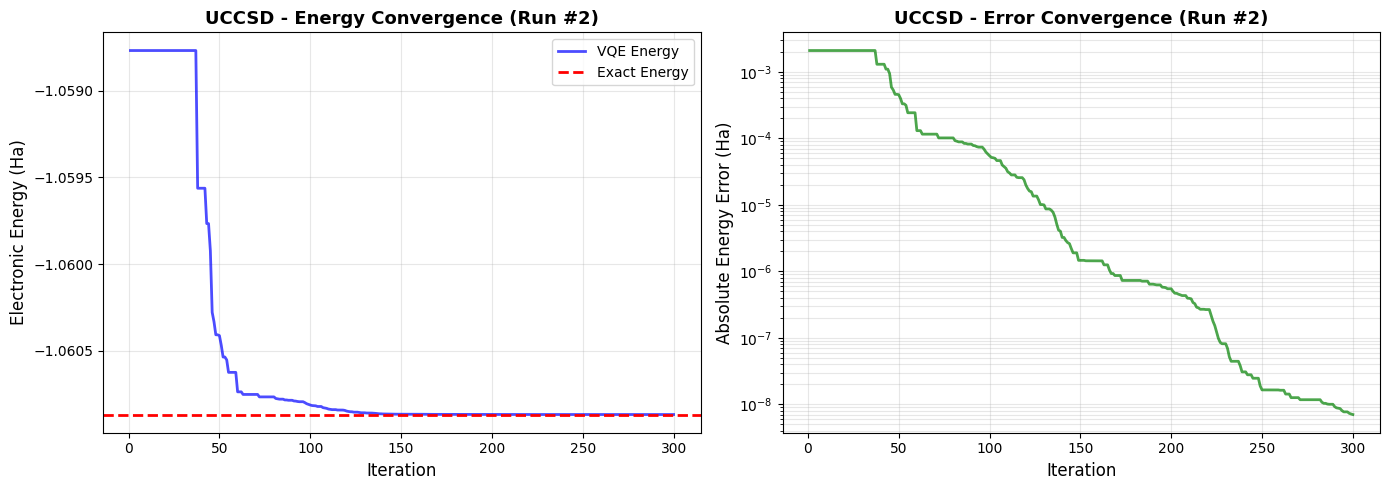

✅ Convergence plot saved: convergence_UCCSD_run2.png


⏱️  Progress: 2/15 complete
   Elapsed: 2.4 min | Estimated remaining: 15.8 min


################################################################################
BENCHMARK 3/15
Ansatz: UCCSD | Run: 3/3
################################################################################

Running: UCCSD - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 15, Depth: 16
⏱️  Starting VQE optimization now...
    Eval 1: E=-1.059153 Ha, Error=1.715 mHa
    Eval 2: E=-0.950025 Ha, Error=110.843 mHa
    Eval 3: E=-0.915577 Ha, Error=145.291 mHa
    Eval 4: E=-0.916106 Ha, Error=144.762 mHa
    Eval 5: E=-0.950678 Ha, Error=110.191 mHa
    Eval 6: E=-0.917594 Ha, Error=143.274 mHa
    Eval 7: E=-0.920540 Ha, Error=140.328 mHa
    Eval 8: E=-0.561608 Ha, Error=499.260 mHa
    Eval 9: E=-0.615884 Ha, Error=444.984 mHa
    Eval 10: E=-0.608076 Ha, Error=452.793 mHa
    Eval 11: E=-0.607376 Ha, Error=453.492 mHa
    Eval 12: E=-0.567237 Ha, Error=

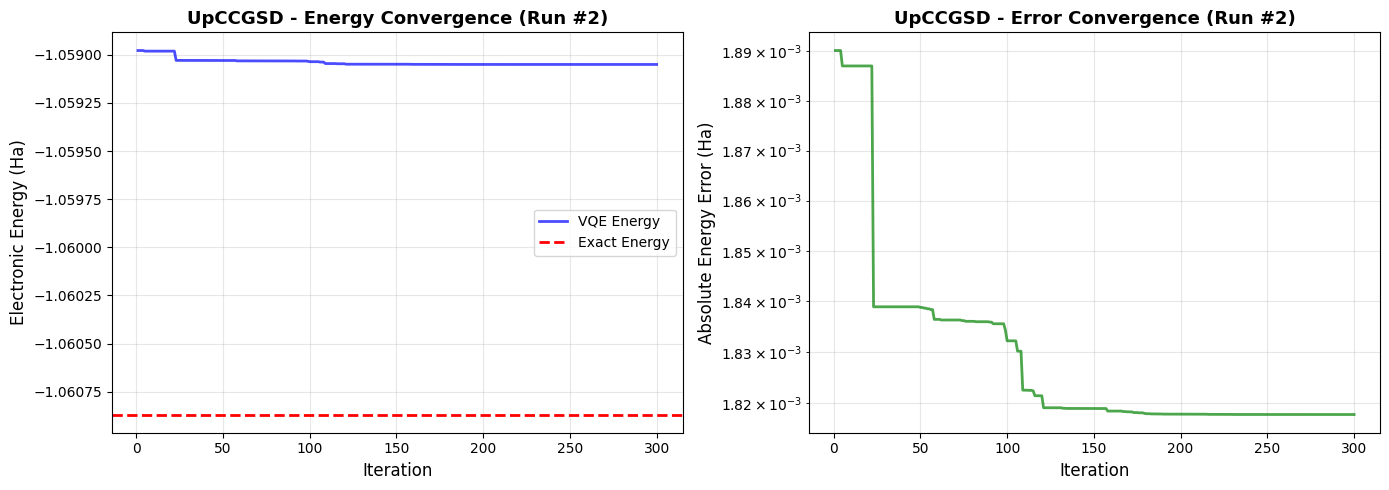

✅ Convergence plot saved: convergence_UpCCGSD_run2.png


⏱️  Progress: 5/15 complete
   Elapsed: 9.6 min | Estimated remaining: 19.1 min


################################################################################
BENCHMARK 6/15
Ansatz: UpCCGSD | Run: 3/3
################################################################################

Running: UpCCGSD - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 36, Depth: 37
⏱️  Starting VQE optimization now...
    Eval 1: E=-1.058979 Ha, Error=1.889 mHa
    Eval 2: E=-0.915476 Ha, Error=145.392 mHa
    Eval 3: E=-1.058979 Ha, Error=1.889 mHa
    Eval 4: E=-1.058979 Ha, Error=1.889 mHa
    Eval 5: E=-1.058978 Ha, Error=1.891 mHa
    Eval 6: E=-1.058979 Ha, Error=1.889 mHa
    Eval 7: E=-1.058979 Ha, Error=1.889 mHa
    Eval 8: E=-0.933728 Ha, Error=127.140 mHa
    Eval 9: E=-1.058979 Ha, Error=1.889 mHa
    Eval 10: E=-1.058979 Ha, Error=1.889 mHa
    Eval 11: E=-0.929771 Ha, Error=131.098 mHa
    Eval 12: E=-1.058979 Ha, Error=1.889 mH

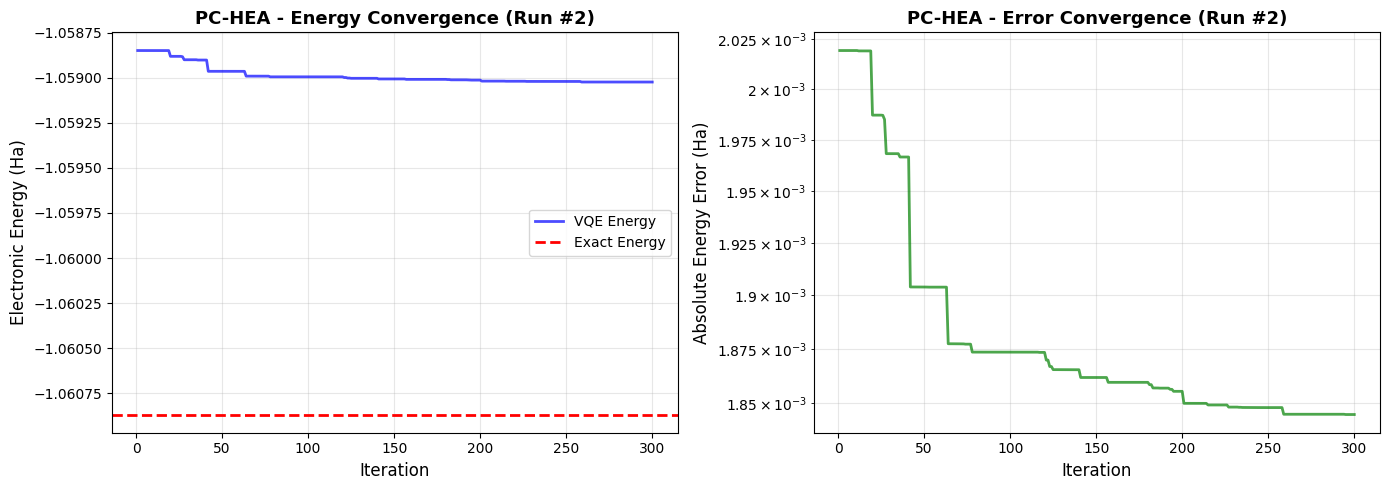

✅ Convergence plot saved: convergence_PC-HEA_run2.png


⏱️  Progress: 8/15 complete
   Elapsed: 12.5 min | Estimated remaining: 11.0 min


################################################################################
BENCHMARK 9/15
Ansatz: PC-HEA | Run: 3/3
################################################################################

Running: PC-HEA - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 96, Depth: 32
⏱️  Starting VQE optimization now...
    Eval 1: E=-1.058868 Ha, Error=2.000 mHa
    Eval 2: E=-1.058868 Ha, Error=2.000 mHa
    Eval 3: E=-1.058868 Ha, Error=2.000 mHa
    Eval 4: E=-1.058868 Ha, Error=2.000 mHa
    Eval 5: E=-1.058868 Ha, Error=2.000 mHa
    Eval 6: E=-1.058868 Ha, Error=2.000 mHa
    Eval 7: E=-1.058868 Ha, Error=2.000 mHa
    Eval 8: E=-1.058868 Ha, Error=2.000 mHa
    Eval 9: E=-1.058868 Ha, Error=2.000 mHa
    Eval 10: E=-0.949727 Ha, Error=111.141 mHa
    Eval 11: E=-1.058868 Ha, Error=2.000 mHa
    Eval 12: E=-1.058867 Ha, Error=2.001 mHa
    

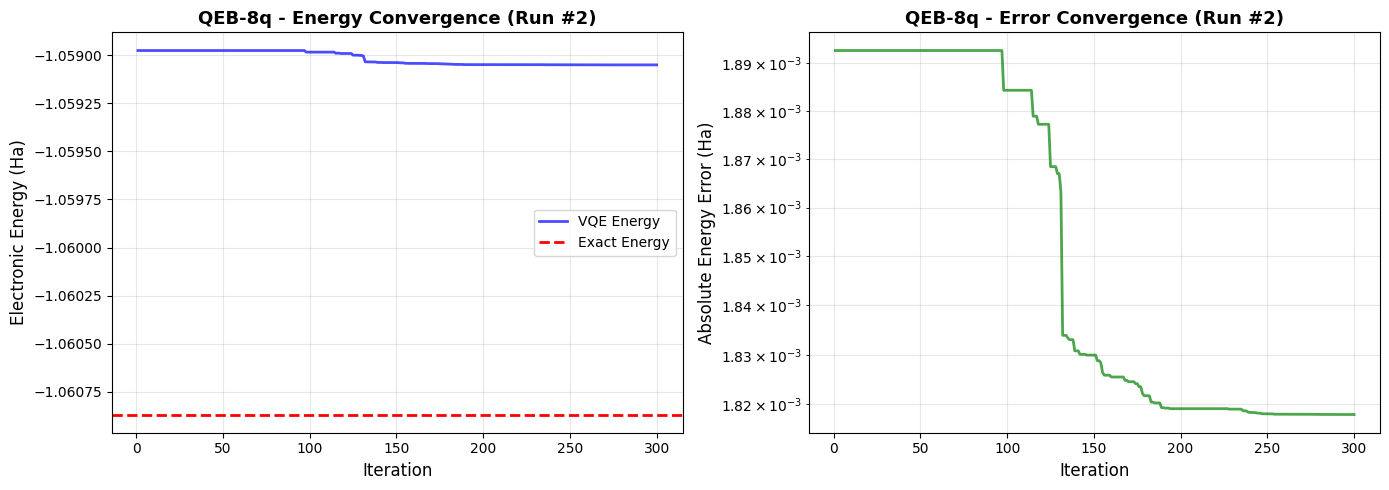

✅ Convergence plot saved: convergence_QEB-8q_run2.png


⏱️  Progress: 11/15 complete
   Elapsed: 12.7 min | Estimated remaining: 4.6 min


################################################################################
BENCHMARK 12/15
Ansatz: QEB-8q | Run: 3/3
################################################################################

Running: QEB-8q - Run #3
Optimizer: COBYLA (maxiter=300)
Parameters: 50, Depth: 149
⏱️  Starting VQE optimization now...
    Eval 1: E=-1.058923 Ha, Error=1.945 mHa
    Eval 2: E=-1.034665 Ha, Error=26.204 mHa
    Eval 3: E=-1.024467 Ha, Error=36.401 mHa
    Eval 4: E=-1.034720 Ha, Error=26.148 mHa
    Eval 5: E=-1.031845 Ha, Error=29.023 mHa
    Eval 6: E=-1.037915 Ha, Error=22.953 mHa
    Eval 7: E=-1.034725 Ha, Error=26.143 mHa
    Eval 8: E=-1.043223 Ha, Error=17.646 mHa
    Eval 9: E=-1.048388 Ha, Error=12.480 mHa
    Eval 10: E=-1.043268 Ha, Error=17.600 mHa
    Eval 11: E=-1.043097 Ha, Error=17.771 mHa
    Eval 12: E=-1.037791 Ha, Error=23.0

In [21]:
# Run all benchmarks by iterating through the ansatz dictionary
all_results = []
total_benchmarks = len(ansatz_dict) * NUM_RUNS
current_benchmark = 0

print("="*80)
print(f"STARTING COMPREHENSIVE BENCHMARK SUITE")
print(f"Total benchmarks to run: {total_benchmarks}")
print(f"Estimated time: {total_benchmarks * 3:.0f}-{total_benchmarks * 5:.0f} minutes")
print("="*80)

benchmark_start_time = time.time()

# Iterate through the ansatz dictionary
for ansatz_name, ansatz in ansatz_dict.items():
    
    if ansatz_name == "QEB-4q":
        print(f"\n" + "="*60)
        print(f"⚠️  QEB-4q uses a different pipeline (4-qubit projected H)")
        print(f"   Skipping in this benchmark loop, will run separately")
        print("="*60)
        continue  # Skip to next ansatz
    # ========================================================================
    
    for run_num in range(1, NUM_RUNS + 1):
        current_benchmark += 1
        
        print(f"\n\n{'#'*80}")
        print(f"BENCHMARK {current_benchmark}/{total_benchmarks}")
        print(f"Ansatz: {ansatz_name} | Run: {run_num}/{NUM_RUNS}")
        print(f"{'#'*80}")
        
        # Run benchmark with the ansatz from dictionary
        result = run_vqe_benchmark(
            ansatz=ansatz,
            ansatz_name=ansatz_name,
            run_number=run_num,
            qubit_op=qubit_op,
            exact_electronic=exact_electronic,
            exact_state=exact_state,
            problem=problem,
            maxiter=300
        )
        
        all_results.append(result)
        
        # Progress update
        elapsed = time.time() - benchmark_start_time
        avg_time_per_run = elapsed / current_benchmark
        remaining = (total_benchmarks - current_benchmark) * avg_time_per_run
        print(f"\n⏱️  Progress: {current_benchmark}/{total_benchmarks} complete")
        print(f"   Elapsed: {elapsed/60:.1f} min | Estimated remaining: {remaining/60:.1f} min")

total_time = time.time() - benchmark_start_time

print(f"\n\n{'='*80}")
print(f"🎉 ALL BENCHMARKS COMPLETE!")
print(f"{'='*80}")
print(f"Total time: {total_time/60:.1f} minutes ({total_time:.0f} seconds)")
print(f"Average time per benchmark: {total_time/total_benchmarks:.1f} seconds")
print(f"Total runs: {len(all_results)}")
print(f"Ansätze tested: {', '.join(ansatz_dict.keys())}")
print(f"{'='*80}\n")



## Step 6b: Run QEB Ansatz Benchmark (Special Pipeline)



RUNNING QEB ANSATZ BENCHMARK
QEB uses a 4-qubit projected Hamiltonian (1α+1β sector)
This requires a different pipeline than the standard 8-qubit ansätze

4-qubit Hamiltonian: 4 qubits, 16 Pauli terms
Exact energy (4q):   -0.91884618 Ha
Exact energy (8q):   -1.06086814 Ha
Difference:          1.420e-01 Ha


QEB Ansatz - Run 1/3
Ansatz parameters: 12
Ansatz depth:      3

Running VQE with COBYLA (maxiter=300)...
Note: COBYLA evaluates multiple trial points per iteration


/var/folders/vv/d2w1vm213_b1g_0lt8qbw49r0000gn/T/ipykernel_20154/4249653048.py:52: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz_qeb = TwoLocal(



Results:
  Electronic energy:  -0.91884618 Ha
  Total energy:       0.07647146 Ha
  Error vs exact (4q): 9.848e-14 Ha
  Total evaluations:   243 (raw)
  Best-so-far points:  243
  Time:                0.27 s

QEB Ansatz - Run 2/3
Ansatz parameters: 12
Ansatz depth:      3

Running VQE with COBYLA (maxiter=300)...
Note: COBYLA evaluates multiple trial points per iteration

Results:
  Electronic energy:  -0.91884618 Ha
  Total energy:       0.07647146 Ha
  Error vs exact (4q): 3.701e-13 Ha
  Total evaluations:   284 (raw)
  Best-so-far points:  284
  Time:                0.31 s

  📊 Run 2 Detailed Error Analysis:
     Absolute energy error: 0.00000000 Ha
     Energy error %:        0.000000%
     Final VQE energy:      -0.91884618 Ha
     Exact energy:          -0.91884618 Ha

📊 PLOTTING CONVERGENCE FOR QEB - RUN #2


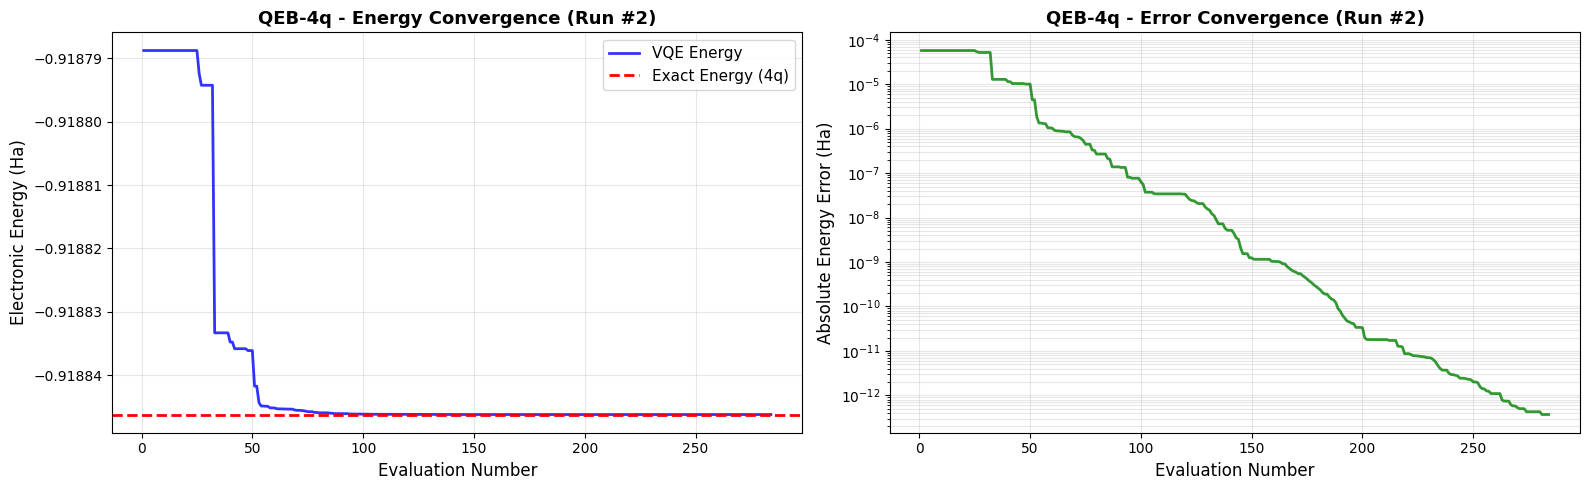


✅ Convergence plots saved to: convergence_QEB_run2.png
   Total Evaluations:       284
   Best-so-far tracked:     284
   Exact Energy (4q):       -0.9188461788 Ha
   Initial Error:           5.7382283200e-05 Ha
   Final Error:             3.7014835641e-13 Ha
   Error Reduction:         155025092.52x

QEB Ansatz - Run 3/3
Ansatz parameters: 12
Ansatz depth:      3

Running VQE with COBYLA (maxiter=300)...
Note: COBYLA evaluates multiple trial points per iteration

Results:
  Electronic energy:  -0.91884618 Ha
  Total energy:       0.07647146 Ha
  Error vs exact (4q): 1.752e-13 Ha
  Total evaluations:   268 (raw)
  Best-so-far points:  268
  Time:                0.30 s

✅ QEB Benchmark Complete!
Total ansätze tested: 1
Total runs in all_results: 15


In [22]:
# ==============================================================
# QEB Ansatz Benchmark (Special 4-Qubit Projected Hamiltonian Pipeline). now using 8-qubit so dont need this
# ==============================================================

print("\n" + "="*70)
print("RUNNING QEB ANSATZ BENCHMARK")
print("="*70)
print("QEB uses a 4-qubit projected Hamiltonian (1α+1β sector)")
print("This requires a different pipeline than the standard 8-qubit ansätze\n")

# Import additional requirements for QEB
from qiskit.quantum_info import Operator, SparsePauliOp

# Project into (1 alpha, 1 beta) sector
Hmat = qubit_op.to_matrix()
dim_full = Hmat.shape[0]
n_qubits = int(np.round(np.log2(dim_full)))

alpha_qubits = list(range(0, n_qubits, 2))
beta_qubits = list(range(1, n_qubits, 2))

basis_indices = []
for a in alpha_qubits:
    for b in beta_qubits:
        idx = (1 << a) | (1 << b)
        basis_indices.append(idx)

basis_indices = np.array(basis_indices, dtype=int)
Heff = Hmat[np.ix_(basis_indices, basis_indices)]

# Re-encode as 4-qubit Hamiltonian
H4_op = Operator(Heff)
H4_pauli = SparsePauliOp.from_operator(H4_op)

print(f"4-qubit Hamiltonian: {H4_pauli.num_qubits} qubits, {len(H4_pauli)} Pauli terms")

# Get exact solution for 4-qubit H
numpy_result4 = numpy_solver.compute_minimum_eigenvalue(H4_pauli)
exact_electronic_4 = numpy_result4.eigenvalue.real

print(f"Exact energy (4q):   {exact_electronic_4:.8f} Ha")
print(f"Exact energy (8q):   {exact_electronic:.8f} Ha")
print(f"Difference:          {abs(exact_electronic_4 - exact_electronic):.3e} Ha\n")

# Run QEB ansatz 3 times
for run_num in range(1, NUM_RUNS + 1):
    print(f"\n{'='*60}")
    print(f"QEB Ansatz - Run {run_num}/{NUM_RUNS}")
    print(f"{'='*60}")
    
    # Create TwoLocal ansatz for 4 qubits
    ansatz_qeb = TwoLocal(
        num_qubits=4,
        rotation_blocks='ry',
        entanglement='full',
        reps=2,
    )
    
    print(f"Ansatz parameters: {ansatz_qeb.num_parameters}")
    print(f"Ansatz depth:      {ansatz_qeb.decompose().depth()}")
    
    # Track convergence with best-so-far
    convergence_history = []
    all_evaluations = []
    best_energy = [float('inf')]
    variance_history = []
    start_time = time.time()
    
    def callback_qeb(eval_count, parameters, mean, std):
        """Callback with best-so-far tracking"""
        # Store all evaluations
        all_evaluations.append(mean)
        
        # Update best-so-far
        if mean < best_energy[0]:
            best_energy[0] = mean
        
        convergence_history.append(best_energy[0])
        
        # Handle std as dict or scalar
        if isinstance(std, dict):
            variance_val = list(std.values())[0] if std else 0.0
        else:
            variance_val = std if std is not None else 0.0
        variance_history.append(variance_val)
    
    # Run VQE with COBYLA (300 iterations)
    optimizer = COBYLA(maxiter=300, tol=1e-6)
    
    vqe_solver = VQE(
        StatevectorEstimator(),
        ansatz_qeb,
        optimizer,
        callback=callback_qeb,
    )
    
    # Use same initialization as other ansätze
    np.random.seed(42 + run_num)  # Different seed per run
    vqe_solver.initial_point = np.random.normal(0, 0.01, size=ansatz_qeb.num_parameters)
    
    print("\nRunning VQE with COBYLA (maxiter=300)...")
    print("Note: COBYLA evaluates multiple trial points per iteration")
    
    result_qeb = vqe_solver.compute_minimum_eigenvalue(H4_pauli)
    
    vqe_elec_4 = result_qeb.eigenvalue.real
    vqe_total_4 = vqe_elec_4 + problem.nuclear_repulsion_energy
    elapsed = time.time() - start_time
    
    print(f"\nResults:")
    print(f"  Electronic energy:  {vqe_elec_4:.8f} Ha")
    print(f"  Total energy:       {vqe_total_4:.8f} Ha")
    print(f"  Error vs exact (4q): {abs(vqe_elec_4 - exact_electronic_4):.3e} Ha")
    print(f"  Total evaluations:   {len(all_evaluations)} (raw)")
    print(f"  Best-so-far points:  {len(convergence_history)}")
    print(f"  Time:                {elapsed:.2f} s")
    
    if run_num == 2:
        abs_error = abs(vqe_elec_4 - exact_electronic_4)
        error_pct = (abs_error / abs(exact_electronic_4)) * 100
        print(f"\n  📊 Run 2 Detailed Error Analysis:")
        print(f"     Absolute energy error: {abs_error:.8f} Ha")
        print(f"     Energy error %:        {error_pct:.6f}%")
        print(f"     Final VQE energy:      {vqe_elec_4:.8f} Ha")
        print(f"     Exact energy:          {exact_electronic_4:.8f} Ha")
        
        # Generate convergence plots for QEB Run 2
        print(f"\n📊 PLOTTING CONVERGENCE FOR QEB - RUN #2")
        print("="*70)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
        
        # Plot 1: Energy convergence
        iterations = range(1, len(convergence_history) + 1)
        ax1.plot(iterations, convergence_history, 'b-', linewidth=2, alpha=0.8, label='VQE Energy')
        ax1.axhline(y=exact_electronic_4, color='r', linestyle='--', linewidth=2, label='Exact Energy (4q)')
        ax1.set_xlabel('Evaluation Number', fontsize=12)
        ax1.set_ylabel('Electronic Energy (Ha)', fontsize=12)
        ax1.set_title(f'QEB-4q - Energy Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Error convergence (log scale)
        absolute_errors = [abs(energy - exact_electronic_4) for energy in convergence_history]
        ax2.semilogy(iterations, absolute_errors, 'g-', linewidth=2, alpha=0.8)
        ax2.set_xlabel('Evaluation Number', fontsize=12)
        ax2.set_ylabel('Absolute Energy Error (Ha)', fontsize=12)
        ax2.set_title(f'QEB-4q - Error Convergence (Run #2)', fontsize=13, fontweight='bold')
        ax2.grid(True, alpha=0.3, which='both')
        
        plt.tight_layout()
        plot_filename = f"convergence_QEB_run2.png"
        plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"\n✅ Convergence plots saved to: {plot_filename}")
        print(f"   Total Evaluations:       {len(all_evaluations)}")
        print(f"   Best-so-far tracked:     {len(convergence_history)}")
        print(f"   Exact Energy (4q):       {exact_electronic_4:.10f} Ha")
        print(f"   Initial Error:           {abs(convergence_history[0] - exact_electronic_4):.10e} Ha")
        print(f"   Final Error:             {abs_error:.10e} Ha")
        print(f"   Error Reduction:         {abs(convergence_history[0] - exact_electronic_4) / abs_error:.2f}x")
        print("="*70)
    
    # Store results (matching schema from run_vqe_benchmark)
    # Calculate state fidelity for QEB
    try:
        final_circuit = ansatz_qeb.assign_parameters(result_qeb.optimal_parameters)
        final_vqe_state_qeb = Statevector(final_circuit)
        # Get exact state for 4-qubit system
        exact_state_4 = Statevector.from_int(0, dims=(2,)*4)  # Placeholder - ideally compute from H4
        final_fidelity = state_fidelity(final_vqe_state_qeb, exact_state_4)
    except:
        final_fidelity = 0.0  # Fallback if fidelity calculation fails
    
    # Find 99% convergence point
    energy_range = convergence_history[0] - exact_electronic_4 if len(convergence_history) > 0 else 1.0
    threshold_99 = exact_electronic_4 + 0.01 * energy_range
    convergence_99_iter = len(convergence_history)
    for idx, energy in enumerate(convergence_history):
        if energy <= threshold_99:
            convergence_99_iter = idx + 1
            break
    
    result_dict = {
        'Ansatz': 'QEB-4q',
        'Run': float(run_num),
        'CNOT_Count': float(ansatz_qeb.decompose().count_ops().get('cx', 0)),
        'Circuit_Depth': float(ansatz_qeb.decompose().depth()),
        'Circuit_Size': float(ansatz_qeb.decompose().size()),
        'Num_Parameters': float(ansatz_qeb.num_parameters),
        'Total_Iterations': float(len(all_evaluations)),
        'Convergence_Speed_99': float(convergence_99_iter),
        'Total_Time_sec': elapsed,
        'Initial_Energy_Ha': convergence_history[0] if len(convergence_history) > 0 else 0.0,
        'Final_Energy_Ha': vqe_elec_4,
        'Exact_Energy_Ha': exact_electronic_4,
        'Energy_Error_Ha': abs(vqe_elec_4 - exact_electronic_4),
        'Energy_Error_Percent': (abs(vqe_elec_4 - exact_electronic_4) / abs(exact_electronic_4)) * 100,
        'State_Fidelity': final_fidelity,
        'Fidelity_Percent': final_fidelity * 100,
        'Avg_Variance': np.mean(variance_history) if variance_history else 0.0,
        'Final_Variance': np.mean(variance_history[-100:]) if len(variance_history) > 100 else (np.mean(variance_history) if variance_history else 0.0),
        'Max_Variance': max(variance_history) if variance_history else 0.0,
        'Min_Variance': min(variance_history) if variance_history else 0.0,
        'Gradient_Indicator': 0.0,  # QEB doesn't track gradients
        'Mean_Gradient': 0.0,
        'Std_Gradient': 0.0,
        'Barren_Plateau_Status': 'N/A',
        '_convergence_history': convergence_history,
        '_all_evaluations': all_evaluations,
        '_note': 'Uses 4-qubit projected Hamiltonian'
    }
    
    all_results.append(result_dict)

print(f"\n✅ QEB Benchmark Complete!")
# Safe check for total ansätze
try:
    unique_ansatze = set([r.get('ansatz_name', 'Unknown') for r in all_results if isinstance(r, dict)])
    print(f"Total ansätze tested: {len(unique_ansatze)}")
except Exception as e:
    print(f"Total ansätze tested: Unable to determine")
print(f"Total runs in all_results: {len(all_results)}")


## Step 7: Aggregate and Analyze Results


In [23]:
# Create DataFrame from all results
results_df = pd.DataFrame([{k: v for k, v in r.items() if not k.startswith('_')} for r in all_results])

# Display full results table
print("="*100)
print("COMPLETE BENCHMARK RESULTS (All Runs)")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Save complete results
results_df.to_csv("benchmark_results_all_runs.csv", index=False)
print(f"\n✅ Complete results saved to: benchmark_results_all_runs.csv")


COMPLETE BENCHMARK RESULTS (All Runs)
 Ansatz  Run  CNOT_Count  Circuit_Depth  Circuit_Size  Num_Parameters  Total_Iterations  Convergence_Speed_99  Total_Time_sec  Initial_Energy_Ha  Final_Energy_Ha  Exact_Energy_Ha  Energy_Error_Ha  Energy_Error_Percent  State_Fidelity  Fidelity_Percent  Avg_Variance  Final_Variance  Max_Variance  Min_Variance  Gradient_Indicator  Mean_Gradient  Std_Gradient Barren_Plateau_Status
  UCCSD  1.0         0.0           16.0          17.0            15.0             300.0                 119.0       72.811967          -1.058211        -1.060868        -1.060868     2.768017e-09          2.609200e-07        1.000000         99.999998           0.0             0.0           0.0           0.0                 0.0            0.0           0.0                   N/A
  UCCSD  2.0         0.0           16.0          17.0            15.0             300.0                 119.0       72.485988          -1.058768        -1.060868        -1.060868     7.006242e-09     

In [24]:
# Calculate aggregated statistics (mean and std across 3 runs for each ansatz)
agg_stats = results_df.groupby('Ansatz').agg({
    'CNOT_Count': ['mean', 'std'],
    'Circuit_Depth': ['mean', 'std'],
    'Circuit_Size': ['mean', 'std'],
    'Num_Parameters': 'first',  # Same for all runs
    'Total_Iterations': ['mean', 'std'],
    'Convergence_Speed_99': ['mean', 'std'],
    'Total_Time_sec': ['mean', 'std'],
    'Energy_Error_Ha': ['mean', 'std'],
    'Energy_Error_Percent': ['mean', 'std'],
    'State_Fidelity': ['mean', 'std'],
    'Fidelity_Percent': ['mean', 'std'],
    'Avg_Variance': ['mean', 'std'],
    'Gradient_Indicator': ['mean', 'std'],
    'Barren_Plateau_Status': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).round(6)

# Flatten column names
agg_stats.columns = ['_'.join(col).strip('_') for col in agg_stats.columns.values]

print("\n" + "="*100)
print("AGGREGATED STATISTICS (Mean ± Std across 3 runs)")
print("="*100)
print(agg_stats.to_string())
print("="*100)

# Save aggregated statistics
agg_stats.to_csv("benchmark_results_aggregated.csv")
print(f"\n✅ Aggregated statistics saved to: benchmark_results_aggregated.csv")



AGGREGATED STATISTICS (Mean ± Std across 3 runs)
         CNOT_Count_mean  CNOT_Count_std  Circuit_Depth_mean  Circuit_Depth_std  Circuit_Size_mean  Circuit_Size_std  Num_Parameters_first  Total_Iterations_mean  Total_Iterations_std  Convergence_Speed_99_mean  Convergence_Speed_99_std  Total_Time_sec_mean  Total_Time_sec_std  Energy_Error_Ha_mean  Energy_Error_Ha_std  Energy_Error_Percent_mean  Energy_Error_Percent_std  State_Fidelity_mean  State_Fidelity_std  Fidelity_Percent_mean  Fidelity_Percent_std  Avg_Variance_mean  Avg_Variance_std  Gradient_Indicator_mean  Gradient_Indicator_std Barren_Plateau_Status_<lambda>
Ansatz                                                                                                                                                                                                                                                                                                                                                                               

In [25]:
# Create comparison summary table with key metrics
comparison_df = results_df.groupby('Ansatz').agg({
    'CNOT_Count': 'mean',
    'Circuit_Depth': 'mean',
    'Num_Parameters': 'first',
    'Convergence_Speed_99': 'mean',
    'Total_Time_sec': 'mean',
    'Energy_Error_Percent': 'mean',
    'State_Fidelity': 'mean',
    'Gradient_Indicator': 'mean',
    'Barren_Plateau_Status': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
}).round(4)

# Rename columns for clarity
comparison_df.columns = [
    'Avg_CNOT',
    'Avg_Depth',
    'Parameters',
    'Conv_Speed_99%',
    'Avg_Time(s)',
    'Avg_Error(%)',
    'Avg_Fidelity',
    'Avg_Gradient',
    'Plateau_Status'
]

# Calculate rankings
comparison_df['CNOT_Rank'] = comparison_df['Avg_CNOT'].rank()
comparison_df['Error_Rank'] = comparison_df['Avg_Error(%)'].rank()
comparison_df['Fidelity_Rank'] = comparison_df['Avg_Fidelity'].rank(ascending=False)
comparison_df['Time_Rank'] = comparison_df['Avg_Time(s)'].rank()
comparison_df['Overall_Rank'] = (
    comparison_df['CNOT_Rank'] + 
    comparison_df['Error_Rank'] + 
    comparison_df['Fidelity_Rank'] + 
    comparison_df['Time_Rank']
) / 4

# Sort by overall rank
comparison_df = comparison_df.sort_values('Overall_Rank')

print("\n" + "="*100)
print("ANSATZ COMPARISON SUMMARY (Averaged across 3 runs)")
print("="*100)
print(comparison_df.to_string())
print("\n" + "="*100)
print("RANKINGS (1 = Best):")
print("  - Lower CNOT count is better (fewer gates)")
print("  - Lower error is better (more accurate)")
print("  - Higher fidelity is better (closer to exact state)")
print("  - Lower time is better (faster convergence)")
print("  - Overall rank is average of all rankings")
print("="*100)

# Save comparison
comparison_df.to_csv("benchmark_comparison_summary.csv")
print(f"\n✅ Comparison summary saved to: benchmark_comparison_summary.csv")



ANSATZ COMPARISON SUMMARY (Averaged across 3 runs)
         Avg_CNOT  Avg_Depth  Parameters  Conv_Speed_99%  Avg_Time(s)  Avg_Error(%)  Avg_Fidelity  Avg_Gradient Plateau_Status  CNOT_Rank  Error_Rank  Fidelity_Rank  Time_Rank  Overall_Rank
Ansatz                                                                                                                                                                                       
QEB-4q        0.0        3.0        12.0         91.3333       0.2937        0.0000        0.9997           0.0            N/A        2.5         1.5            2.0        1.0         1.750
UCCSD         0.0       16.0        15.0        127.6667      72.4880        0.0000        1.0000           0.0            N/A        2.5         1.5            1.0        4.0         2.250
PC-HEA        0.0       32.0        96.0        300.0000       1.5788        0.1759        0.9969           0.0            N/A        2.5         5.0            5.0        2.0         3.62

## Step 8: Comprehensive Visualizations


Plotting ansätze: ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']


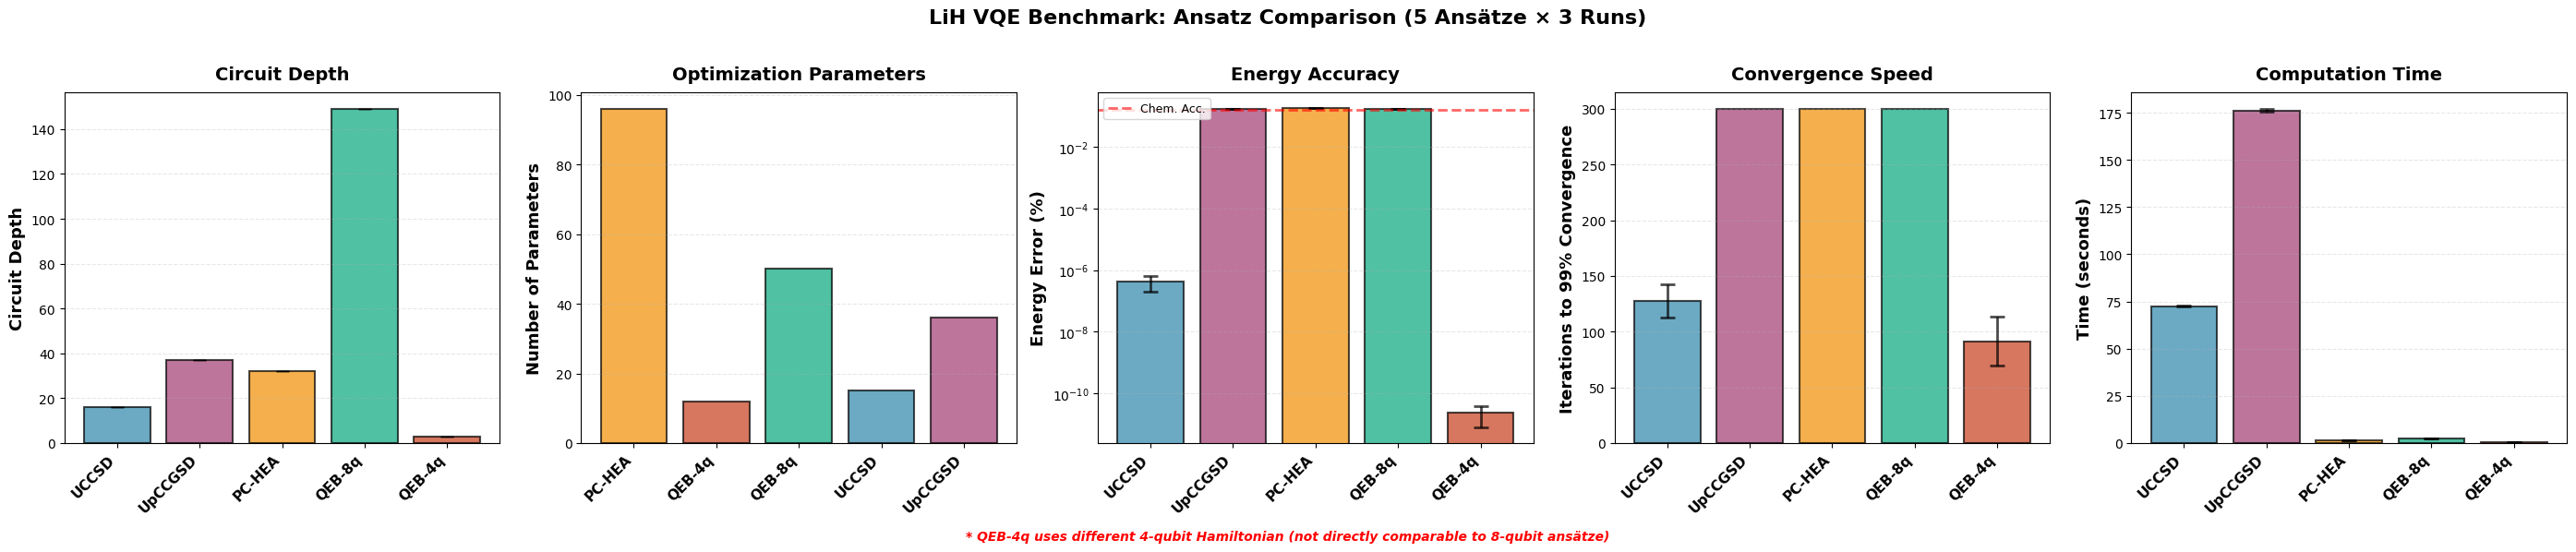

Results check:

UCCSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 72.49 sec
  Avg Error: 0.000000%
  Avg Iters: 300
  Circuit Depth: 16

UpCCGSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 176.28 sec
  Avg Error: 0.171354%
  Avg Iters: 300
  Circuit Depth: 37

PC-HEA:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 1.58 sec
  Avg Error: 0.175857%
  Avg Iters: 300
  Circuit Depth: 32

QEB-8q:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 2.28 sec
  Avg Error: 0.171372%
  Avg Iters: 300
  Circuit Depth: 149

QEB-4q:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 0.29 sec
  Avg Error: 0.000000%
  Avg Iters: 265
  Circuit Depth: 3

Convergence check:
PC-HEA: 0 evaluations
QEB-8q: 0 evaluations
QEB-4q: 0 evaluations


In [26]:

# =============================================================================
# STEP 8: COMPARISON PLOTS 
# =============================================================================

ansatz_names = list(ansatz_dict.keys())
ansatz_names_with_data = results_df['Ansatz'].unique().tolist()
ansatz_names_with_data = [name for name in ansatz_names_with_data if pd.notna(name)]
print(f"Plotting ansätze: {ansatz_names_with_data}")

# Define specific colors for each ansatz (consistent coloring)
color_map = {
    'UCCSD': '#2E86AB',      # Blue
    'UpCCGSD': '#A23B72',    # Purple
    'PC-HEA': '#F18F01',     # Orange
    'QEB-8q': '#06A77D',     # Green
    'QEB-4q': '#C73E1D'      # Red
}

# Create figure: 1 ROW, 5 COLUMNS 
fig, axes = plt.subplots(1, 5, figsize=(28, 6))

# ============================================================================
# PLOT 1: Circuit Depth
# ============================================================================
ax = axes[0]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Circuit_Depth']
    ax.bar(i, data.mean(), yerr=data.std(), color=color_map.get(ansatz, '#999999'), 
           alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Circuit Depth', fontsize=13, fontweight='bold')
ax.set_title('Circuit Depth', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 2: Number of Parameters
# ============================================================================
ax = axes[1]
params_data = results_df.groupby('Ansatz')['Num_Parameters'].first()
ax.bar(range(len(params_data)), params_data.values, 
       color=[color_map.get(a, '#999999') for a in params_data.index], 
       alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(params_data.index, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Parameters', fontsize=13, fontweight='bold')
ax.set_title('Optimization Parameters', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 3: Energy Error 
# ============================================================================
ax = axes[2]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Energy_Error_Percent']
    # Filter valid data for log scale
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Add error bar with proper handling for log scale
        if pd.notna(std_val) and std_val > 0:
            # For log scale, use asymmetric error bars
            lower_err = mean_val - max(mean_val * 0.1, mean_val - std_val)
            upper_err = std_val
            ax.errorbar(i, mean_val, yerr=[[lower_err], [upper_err]], 
                       fmt='none', ecolor='black', capsize=6, capthick=2, 
                       elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Energy Error (%)', fontsize=13, fontweight='bold')
ax.set_title('Energy Accuracy', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', which='both', linestyle='--')
ax.set_yscale('log')
# Add chemical accuracy reference
ax.axhline(y=0.16, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label='Chem. Acc.')
ax.legend(fontsize=9, loc='upper left')

# ============================================================================
# PLOT 4: Convergence Speed
# ============================================================================
ax = axes[3]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Convergence_Speed_99']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Iterations to 99% Convergence', fontsize=13, fontweight='bold')
ax.set_title('Convergence Speed', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 5: Computation Time
# ============================================================================
ax = axes[4]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Total_Time_sec']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Computation Time', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add footnote about QEB-4q if present
if 'QEB-4q' in ansatz_names_with_data:
    fig.text(0.5, 0.02, '* QEB-4q uses different 4-qubit Hamiltonian (not directly comparable to 8-qubit ansätze)', 
             ha='center', fontsize=10, style='italic', color='red', weight='bold')

# Overall title
plt.suptitle(f'LiH VQE Benchmark: Ansatz Comparison ({len(ansatz_names_with_data)} Ansätze × {NUM_RUNS} Runs)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('benchmark_comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()


print("Results check:")
for ansatz in ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz]
    print(f"\n{ansatz}:")
    print(f"  Rows: {len(data)}")
    print(f"  Runs: {data['Run'].unique()}")
    print(f"  Avg Time: {data['Total_Time_sec'].mean():.2f} sec")
    print(f"  Avg Error: {data['Energy_Error_Percent'].mean():.6f}%")
    print(f"  Avg Iters: {data['Total_Iterations'].mean():.0f}")
    print(f"  Circuit Depth: {data['Circuit_Depth'].mean():.0f}")

print("\nConvergence check:")
for ansatz in ['PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz].iloc[0]
    conv_hist = data.get('_convergence_history', [])
    print(f"{ansatz}: {len(conv_hist)} evaluations")
    if len(conv_hist) > 0:
        print(f"  Initial: {conv_hist[0]:.6f} Ha")
        print(f"  Final: {conv_hist[-1]:.6f} Ha")


Plotting ansätze: ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']


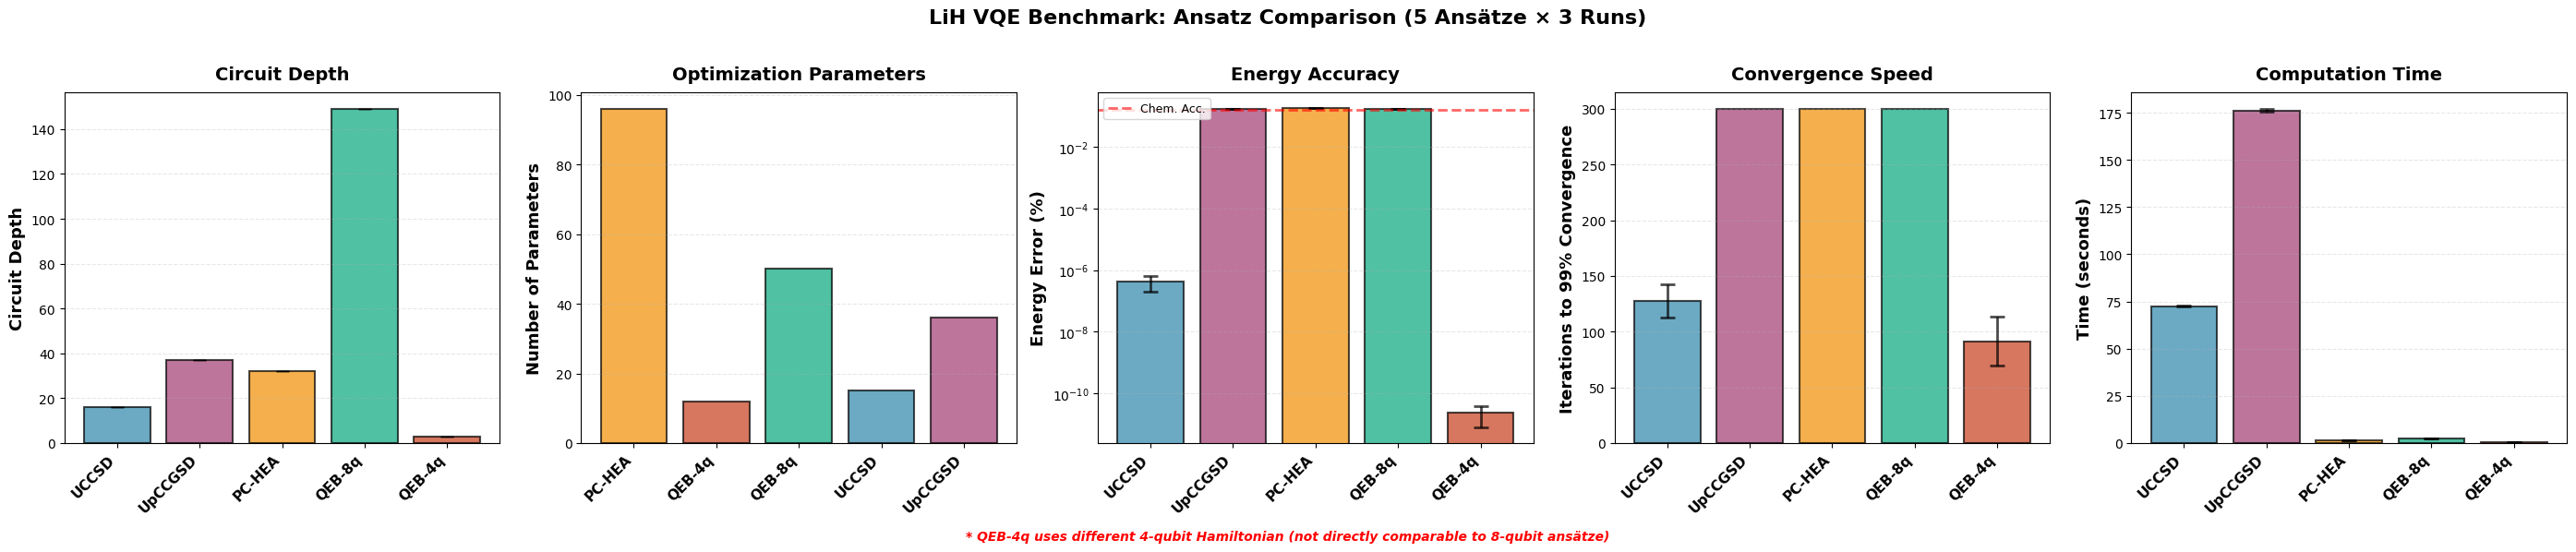

Results check:

UCCSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 72.49 sec
  Avg Error: 0.000000%
  Avg Iters: 300
  Circuit Depth: 16

UpCCGSD:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 176.28 sec
  Avg Error: 0.171354%
  Avg Iters: 300
  Circuit Depth: 37

PC-HEA:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 1.58 sec
  Avg Error: 0.175857%
  Avg Iters: 300
  Circuit Depth: 32

QEB-8q:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 2.28 sec
  Avg Error: 0.171372%
  Avg Iters: 300
  Circuit Depth: 149

QEB-4q:
  Rows: 3
  Runs: [1. 2. 3.]
  Avg Time: 0.29 sec
  Avg Error: 0.000000%
  Avg Iters: 265
  Circuit Depth: 3

Convergence check:
PC-HEA: 0 evaluations
QEB-8q: 0 evaluations
QEB-4q: 0 evaluations


In [27]:

# =============================================================================
# STEP 8: COMPARISON PLOTS 
# =============================================================================

ansatz_names = list(ansatz_dict.keys())
ansatz_names_with_data = results_df['Ansatz'].unique().tolist()
ansatz_names_with_data = [name for name in ansatz_names_with_data if pd.notna(name)]
print(f"Plotting ansätze: {ansatz_names_with_data}")

# Define specific colors for each ansatz (consistent coloring)
color_map = {
    'UCCSD': '#2E86AB',      # Blue
    'UpCCGSD': '#A23B72',    # Purple
    'PC-HEA': '#F18F01',     # Orange
    'QEB-8q': '#06A77D',     # Green
    'QEB-4q': '#C73E1D'      # Red
}

# Create figure: 1 ROW, 5 COLUMNS 
fig, axes = plt.subplots(1, 5, figsize=(28, 6))

# ============================================================================
# PLOT 1: Circuit Depth
# ============================================================================
ax = axes[0]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Circuit_Depth']
    ax.bar(i, data.mean(), yerr=data.std(), color=color_map.get(ansatz, '#999999'), 
           alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Circuit Depth', fontsize=13, fontweight='bold')
ax.set_title('Circuit Depth', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 2: Number of Parameters
# ============================================================================
ax = axes[1]
params_data = results_df.groupby('Ansatz')['Num_Parameters'].first()
ax.bar(range(len(params_data)), params_data.values, 
       color=[color_map.get(a, '#999999') for a in params_data.index], 
       alpha=0.7, edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(params_data.index, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Parameters', fontsize=13, fontweight='bold')
ax.set_title('Optimization Parameters', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 3: Energy Error 
# ============================================================================
ax = axes[2]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Energy_Error_Percent']
    # Filter valid data for log scale
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        # Add error bar with proper handling for log scale
        if pd.notna(std_val) and std_val > 0:
            # For log scale, use asymmetric error bars
            lower_err = mean_val - max(mean_val * 0.1, mean_val - std_val)
            upper_err = std_val
            ax.errorbar(i, mean_val, yerr=[[lower_err], [upper_err]], 
                       fmt='none', ecolor='black', capsize=6, capthick=2, 
                       elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Energy Error (%)', fontsize=13, fontweight='bold')
ax.set_title('Energy Accuracy', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', which='both', linestyle='--')
ax.set_yscale('log')
# Add chemical accuracy reference
ax.axhline(y=0.16, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label='Chem. Acc.')
ax.legend(fontsize=9, loc='upper left')

# ============================================================================
# PLOT 4: Convergence Speed
# ============================================================================
ax = axes[3]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Convergence_Speed_99']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Iterations to 99% Convergence', fontsize=13, fontweight='bold')
ax.set_title('Convergence Speed', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# ============================================================================
# PLOT 5: Computation Time
# ============================================================================
ax = axes[4]
for i, ansatz in enumerate(ansatz_names_with_data):
    data = results_df[results_df['Ansatz'] == ansatz]['Total_Time_sec']
    # Filter valid data
    valid_data = data[np.isfinite(data) & (data > 0)]
    
    if len(valid_data) > 0:
        mean_val = valid_data.mean()
        std_val = valid_data.std()
        
        ax.bar(i, mean_val, color=color_map.get(ansatz, '#999999'), 
               alpha=0.7, edgecolor='black', linewidth=1.5)
        
        if pd.notna(std_val) and std_val > 0:
            ax.errorbar(i, mean_val, yerr=std_val, fmt='none', ecolor='black', 
                       capsize=6, capthick=2, elinewidth=2, alpha=0.7)

ax.set_xticks(range(len(ansatz_names_with_data)))
ax.set_xticklabels(ansatz_names_with_data, rotation=45, ha='right', fontsize=11, fontweight='bold')
ax.set_ylabel('Time (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Computation Time', fontweight='bold', fontsize=14, pad=10)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

# Add footnote about QEB-4q if present
if 'QEB-4q' in ansatz_names_with_data:
    fig.text(0.5, 0.02, '* QEB-4q uses different 4-qubit Hamiltonian (not directly comparable to 8-qubit ansätze)', 
             ha='center', fontsize=10, style='italic', color='red', weight='bold')

# Overall title
plt.suptitle(f'LiH VQE Benchmark: Ansatz Comparison ({len(ansatz_names_with_data)} Ansätze × {NUM_RUNS} Runs)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.04, 1, 0.96])
plt.savefig('benchmark_comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()


print("Results check:")
for ansatz in ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz]
    print(f"\n{ansatz}:")
    print(f"  Rows: {len(data)}")
    print(f"  Runs: {data['Run'].unique()}")
    print(f"  Avg Time: {data['Total_Time_sec'].mean():.2f} sec")
    print(f"  Avg Error: {data['Energy_Error_Percent'].mean():.6f}%")
    print(f"  Avg Iters: {data['Total_Iterations'].mean():.0f}")
    print(f"  Circuit Depth: {data['Circuit_Depth'].mean():.0f}")

print("\nConvergence check:")
for ansatz in ['PC-HEA', 'QEB-8q', 'QEB-4q']:
    data = results_df[results_df['Ansatz'] == ansatz].iloc[0]
    conv_hist = data.get('_convergence_history', [])
    print(f"{ansatz}: {len(conv_hist)} evaluations")
    if len(conv_hist) > 0:
        print(f"  Initial: {conv_hist[0]:.6f} Ha")
        print(f"  Final: {conv_hist[-1]:.6f} Ha")



CREATING UNIFIED CONVERGENCE COMPARISON PLOT


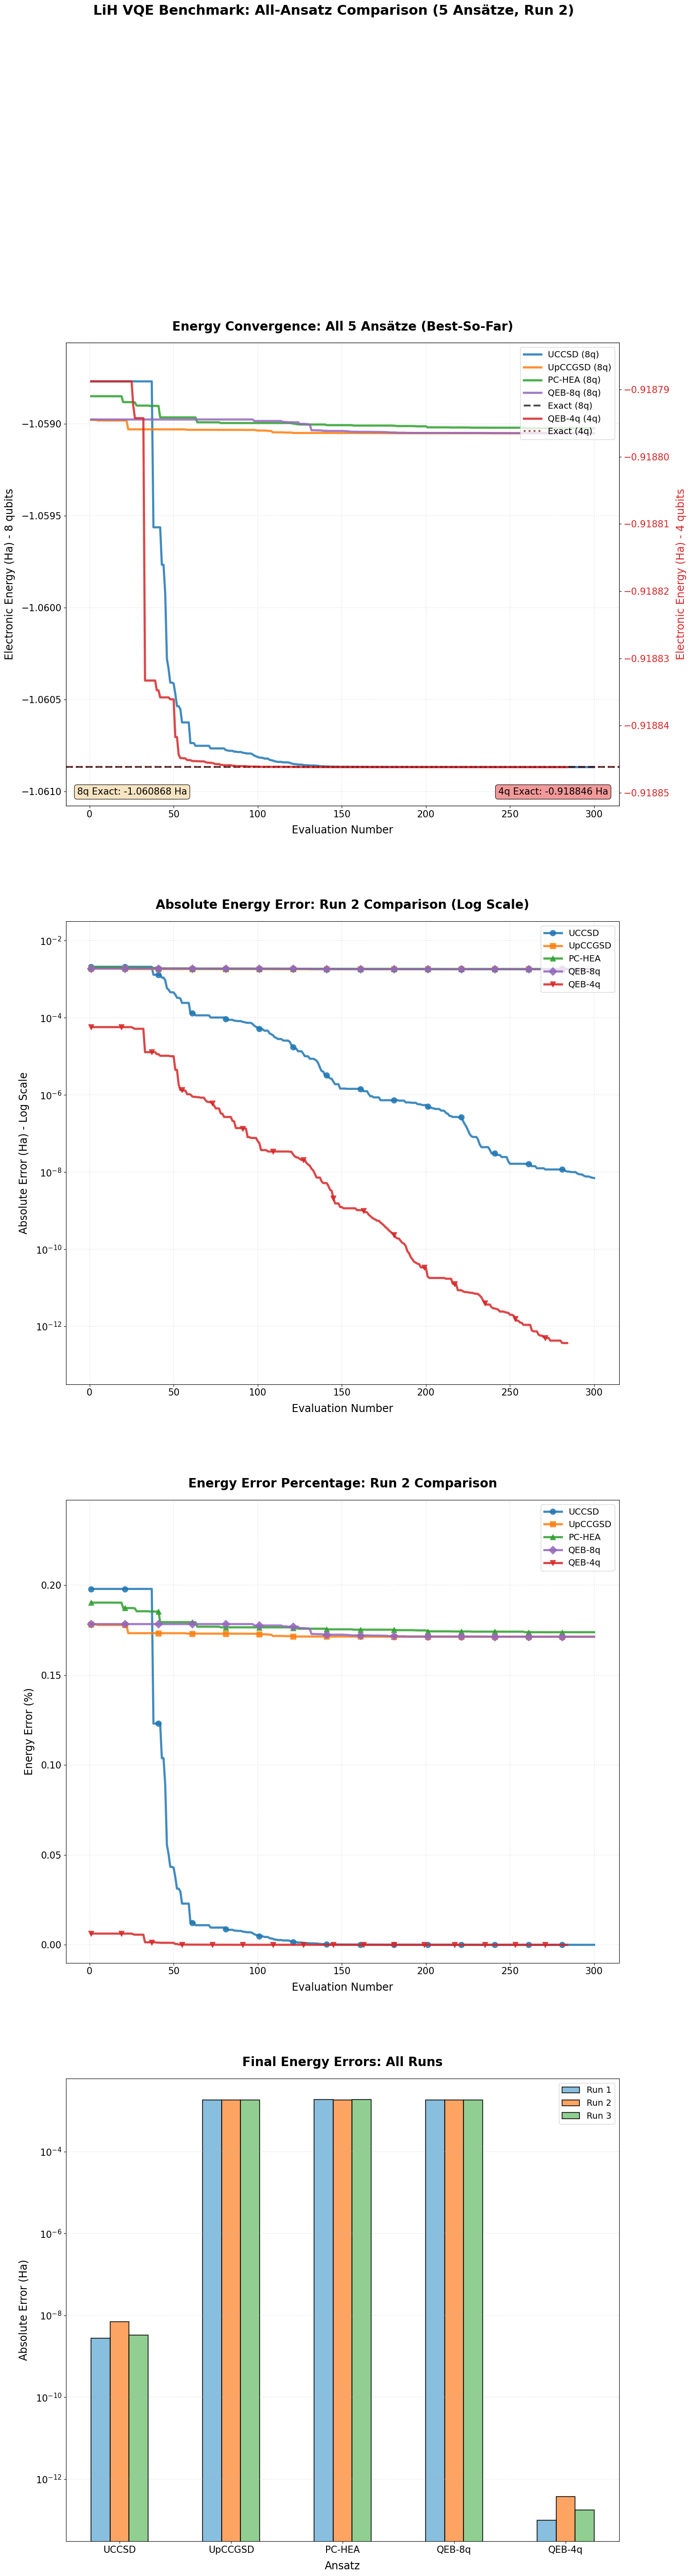


✅ Comprehensive convergence comparison plot saved!
   File: all_5_ansatz_convergence_comparison.png
   Ansätze plotted: ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']


In [28]:
# ==============================================================
# All-Ansatz Convergence Comparison (Best-So-Far)
# ==============================================================

print("\n" + "="*70)
print("CREATING UNIFIED CONVERGENCE COMPARISON PLOT")
print("="*70)

# Define all 5 ansätze for this unified plot
ansatz_names_all = ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q', 'QEB-4q']

# Create a comprehensive comparison plot showing all 5 ansätze
# Changed to taller figure with square-ish subplots
fig = plt.figure(figsize=(16, 64))  # Even taller for 4 subplots
gs = fig.add_gridspec(4, 1, hspace=0.25)

colors = {
    'UCCSD': '#1f77b4',
    'UpCCGSD': '#ff7f0e', 
    'PC-HEA': '#2ca02c',
    'QEB-8q': '#9467bd',  # Purple for 8q QEB
    'QEB-4q': '#d62728'   # Red for 4q QEB (same as 'QEB' in final-1)
}

markers = {
    'UCCSD': 'o',
    'UpCCGSD': 's',
    'PC-HEA': '^',
    'QEB-8q': 'D',
    'QEB-4q': 'v'
}

# Plot 1: Energy Convergence (Best-So-Far) with Dual Y-Axis
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Energy Convergence: All 5 Ansätze (Best-So-Far)', fontsize=20, fontweight='bold', pad=20)

# Collect all 8q data to determine range (including QEB-8q now)
all_8q_energies = []
for ansatz_name in ['UCCSD', 'UpCCGSD', 'PC-HEA', 'QEB-8q']:
    ansatz_results = [r for r in all_results if isinstance(r, dict) and 
                     r.get('Ansatz') == ansatz_name and r.get('Run') == 2]
    if not ansatz_results:
        continue
    result = ansatz_results[0]
    conv_hist = result.get('_convergence_history', [])
    all_8q_energies.extend(conv_hist)
    iterations = range(1, len(conv_hist) + 1)
    ax1.plot(iterations, conv_hist, color=colors[ansatz_name], 
            linewidth=3.5, label=f"{ansatz_name} (8q)", alpha=0.85)

ax1.axhline(y=exact_electronic, color='black', linestyle='--', linewidth=3, 
           alpha=0.7, label='Exact (8q)')
all_8q_energies.append(exact_electronic)

# Add text annotation for 8q exact energy
ax1.text(0.02, 0.02, f'8q Exact: {exact_electronic:.6f} Ha', 
         transform=ax1.transAxes, fontsize=15, verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax1.set_xlabel('Evaluation Number', fontsize=17, labelpad=10)
ax1.set_ylabel('Electronic Energy (Ha) - 8 qubits', fontsize=17, color='black', labelpad=10)
# Add 10% padding to the range
energy_range_8q = max(all_8q_energies) - min(all_8q_energies)
padding_8q = energy_range_8q * 0.10
ax1.set_ylim(min(all_8q_energies) - padding_8q, max(all_8q_energies) + padding_8q)
ax1.tick_params(axis='y', labelcolor='black', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.grid(True, alpha=0.4, linestyle=':', linewidth=1.2)

# Create secondary y-axis for QEB-4q
ax1_right = ax1.twinx()
# Get the LONGEST QEB-4q run (300 iterations from final benchmark)
qeb_results = [r for r in all_results if isinstance(r, dict) and 
              r.get('Ansatz') == 'QEB-4q' and r.get('Run') == 2]
if qeb_results:
    # Find the run with most iterations
    result = max(qeb_results, key=lambda r: r.get('Total_Iterations', 0))
    conv_hist = result.get('_convergence_history', [])
    iterations = range(1, len(conv_hist) + 1)
    ax1_right.plot(iterations, conv_hist, color=colors['QEB-4q'], 
                  linewidth=3.5, label=f"QEB-4q (4q)", alpha=0.85)
    
    exact_4q = result['Exact_Energy_Ha']
    ax1_right.axhline(y=exact_4q, color='darkred', linestyle=':', 
                     linewidth=3, alpha=0.7, label='Exact (4q)')
    
    # Add text annotation for 4q exact energy
    ax1_right.text(0.98, 0.02, f'4q Exact: {exact_4q:.6f} Ha', 
                   transform=ax1.transAxes, fontsize=15, verticalalignment='bottom',
                   horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    ax1_right.set_ylabel('Electronic Energy (Ha) - 4 qubits', fontsize=17, 
                         color=colors['QEB-4q'], labelpad=10)
    ax1_right.tick_params(axis='y', labelcolor=colors['QEB-4q'], labelsize=15)
    # Add 10% padding to QEB range
    all_4q_energies = conv_hist + [exact_4q]
    energy_range_4q = max(all_4q_energies) - min(all_4q_energies)
    padding_4q = energy_range_4q * 0.10
    ax1_right.set_ylim(min(all_4q_energies) - padding_4q, max(all_4q_energies) + padding_4q)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_right.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=14, loc='upper right')

# Plot 2: Absolute Error (Log Scale)
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title('Absolute Energy Error: Run 2 Comparison (Log Scale)', 
              fontsize=20, fontweight='bold', pad=20)

# Collect all error data to determine range
all_errors = []
for ansatz_name in ansatz_names_all:
    ansatz_results = [r for r in all_results if isinstance(r, dict) and 
                     r.get('Ansatz') == ansatz_name and r['Run'] == 2]
    if not ansatz_results:
        continue
    
    # Get the longest run
    result = max(ansatz_results, key=lambda r: r.get('Total_Iterations', 0))
    
    conv_hist = result.get('_convergence_history', [])
    exact = result['Exact_Energy_Ha']
    errors = [abs(e - exact) for e in conv_hist]
    all_errors.extend(errors)
    iterations = range(1, len(errors) + 1)
    ax2.semilogy(iterations, errors, color=colors[ansatz_name], 
                linewidth=3.5, label=ansatz_name, marker=markers[ansatz_name],
                markevery=max(1, len(errors)//15), markersize=9, alpha=0.85)

ax2.set_xlabel('Evaluation Number', fontsize=17, labelpad=10)
ax2.set_ylabel('Absolute Error (Ha) - Log Scale', fontsize=17, labelpad=10)
ax2.legend(fontsize=14, loc='upper right')
ax2.grid(True, alpha=0.4, which='both', linestyle=':', linewidth=1.2)
# Set range with padding - use powers of 10 for log scale
min_error = min([e for e in all_errors if e > 0])  # Avoid log(0)
max_error = max(all_errors)
# Go down one order of magnitude below min, up one above max
ax2.set_ylim(10**(np.floor(np.log10(min_error)) - 0.5), 
             10**(np.ceil(np.log10(max_error)) + 0.5))
ax2.tick_params(labelsize=15)

# Plot 3: Energy Error Percentage (Linear Scale)
ax3 = fig.add_subplot(gs[2, 0])
ax3.set_title('Energy Error Percentage: Run 2 Comparison', 
              fontsize=20, fontweight='bold', pad=20)

# Collect all percentage error data
all_errors_pct = []
for ansatz_name in ansatz_names_all:
    ansatz_results = [r for r in all_results if isinstance(r, dict) and 
                     r.get('Ansatz') == ansatz_name and r['Run'] == 2]
    if not ansatz_results:
        continue
    
    # Get the longest run
    result = max(ansatz_results, key=lambda r: r.get('Total_Iterations', 0))
    
    conv_hist = result.get('_convergence_history', [])
    exact = result['Exact_Energy_Ha']
    # Calculate percentage error
    errors_pct = [(abs(e - exact) / abs(exact)) * 100 for e in conv_hist]
    all_errors_pct.extend(errors_pct)
    iterations = range(1, len(errors_pct) + 1)
    ax3.plot(iterations, errors_pct, color=colors[ansatz_name], 
            linewidth=3.5, label=ansatz_name, marker=markers[ansatz_name],
            markevery=max(1, len(errors_pct)//15), markersize=9, alpha=0.85)

ax3.set_xlabel('Evaluation Number', fontsize=17, labelpad=10)
ax3.set_ylabel('Energy Error (%)', fontsize=17, labelpad=10)
ax3.legend(fontsize=14, loc='upper right')
ax3.grid(True, alpha=0.4, linestyle=':', linewidth=1.2)
ax3.tick_params(labelsize=15)

# Much more aggressive padding for Graph 3
min_pct = min(all_errors_pct)
max_pct = max(all_errors_pct)
range_pct = max_pct - min_pct

# Use 25% relative padding OR at least 0.02% absolute padding
relative_padding = range_pct * 0.25
abs_padding = 0.02  # 0.02% minimum padding
padding_pct = max(relative_padding, abs_padding)

# Set limits with guaranteed space at bottom
y_min = max(0, min_pct - padding_pct)
y_max = max_pct + padding_pct

# If y_min is still very close to 0, add a bit more
if y_min < 0.01:
    y_min = -0.01  # Small negative value to ensure visible space

ax3.set_ylim(y_min, y_max)

# Plot 4: Final Energy Error Bar Chart - ALL RUNS
ax4 = fig.add_subplot(gs[3, 0])
ax4.set_title('Final Energy Errors: All Runs', 
              fontsize=20, fontweight='bold', pad=20)

# Collect final errors for each ansatz across all runs
run_colors = {1: '#6baed6', 2: '#fd8d3c', 3: '#74c476'}  # Blue, Orange, Green
bar_width = 0.17  # Narrower bars for 5 ansätze
x_positions = np.arange(len(ansatz_names_all))

# For each run, collect final errors
for run_idx in [1, 2, 3]:
    errors_for_run = []
    for ansatz_name in ansatz_names_all:
        ansatz_results = [r for r in all_results if isinstance(r, dict) and 
                         r.get('Ansatz') == ansatz_name and r.get('Run') == run_idx]
        if not ansatz_results:
            errors_for_run.append(0)
            continue
        
        # Get the longest run for this specific run number
        result = max(ansatz_results, key=lambda r: r.get('Total_Iterations', 0))
        
        conv_hist = result.get('_convergence_history', [])
        if conv_hist:
            final_energy = conv_hist[-1]
            exact = result['Exact_Energy_Ha']
            final_error = abs(final_energy - exact)
            errors_for_run.append(final_error)
        else:
            errors_for_run.append(0)
    
    # Plot bars for this run
    offset = (run_idx - 2) * bar_width  # -1, 0, +1 for runs 1, 2, 3
    ax4.bar(x_positions + offset, errors_for_run, bar_width, 
            label=f'Run {run_idx}', color=run_colors[run_idx], 
            alpha=0.8, edgecolor='black', linewidth=1.5)

ax4.set_xlabel('Ansatz', fontsize=17, labelpad=10)
ax4.set_ylabel('Absolute Error (Ha)', fontsize=17, labelpad=10)
ax4.set_xticks(x_positions)
ax4.set_xticklabels(ansatz_names_all, fontsize=15)
ax4.tick_params(axis='y', labelsize=15)
ax4.legend(fontsize=14, loc='upper right')
ax4.grid(True, alpha=0.4, axis='y', linestyle=':', linewidth=1.2)
ax4.set_yscale('log')  # Use log scale like in the reference image

plt.suptitle('LiH VQE Benchmark: All-Ansatz Comparison (5 Ansätze, Run 2)', 
             fontsize=22, fontweight='bold', y=0.9985)
plt.savefig('all_5_ansatz_convergence_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comprehensive convergence comparison plot saved!")
print("   File: all_5_ansatz_convergence_comparison.png")
print(f"   Ansätze plotted: {ansatz_names_all}")
